# data preprocessing

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/workspace/24_pose/data'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'my_models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [2]:
print(tf.__version__)

2.6.0


In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [2]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/workspace/24_pose/data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


# TFRecord 파일 만들기
[TFRecord공식문서](https://www.tensorflow.org/guide/data_performance?hl=ko)

In [5]:
# TFRecord는 tf.train.Example의 합으로 이루어짐으로
# 위 annotaion을 하나의 tf.train.Example로 만들기
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [3]:
# TFRecord를 얼마나 많이 만들지 (chunk)함수
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

[ray 공식문서](https://www.ray.io)

In [8]:
# @ray.remote
# 병렬, 분산 처리를 위한 데코 1. 함수의 원격 실행, 2. 클래스의 원격 인스턴스 생성 와 같은 기능을하며 비동기적으로 실행행됨
# ray.get을 통해 값을 가져올 수도 있다
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2024-07-18 07:47:58,560	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.80gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/workspace/24_pose/data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/workspace/24_pose/data/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [

(build_single_tfrecord pid=898) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0021_of_0064.tfrecords
(build_single_tfrecord pid=898) start to build tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=899) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0023_of_0064.tfrecords
(build_single_tfrecord pid=899) start to build tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=900) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0024_of_0064.tfrecords
(build_single_tfrecord pid=900) start to build tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=898) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_002

(build_single_tfrecord pid=898) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0048_of_0064.tfrecords
(build_single_tfrecord pid=898) start to build tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0051_of_0064.tfrecords
(build_single_tfrecord pid=900) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0049_of_0064.tfrecords
(build_single_tfrecord pid=900) start to build tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0052_of_0064.tfrecords
(build_single_tfrecord pid=899) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0050_of_0064.tfrecords
(build_single_tfrecord pid=899) start to build tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_0053_of_0064.tfrecords
(build_single_tfrecord pid=898) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/train_005

# data label 만들기

In [11]:
# TFRecord는 직렬화된 데이터이기 때문에
# 만들때 데이터 순서와 읽어올 때 데이터 순서가 같아야한다는점을 주의
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

(build_single_tfrecord pid=899) finished building tf records for /aiffel/aiffel/workspace/24_pose/data/tfrecords_mpii/val_0008_of_0008.tfrecords


In [12]:
# image와 label을 이용해서 적절한 학습 형태 (적당히 정사각형으로 crop 하여)
# joints, center, body height 값을 활용하여 임의로 조정한 정사각형으로 crop한 범위가 이미지 바깥으로 나가지 않게 예외처리
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

In [2]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

In [22]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [23]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [24]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [25]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [3]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 model_type,
                 start_epoch):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        # "we use rmsprop with a learning rate of 2.5e-4.""
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        self.model_type = model_type
        self.start_epoch = start_epoch

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        # loss = 0 -> loss = 0.
        loss = 0.
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
#             print(f'label = {labels}, {labels.dtype}')
#             print(f'output = {output}, {output.dtype}')
#             print(f'square: \n {tf.math.square(labels - output) * weights}\n\n')
#             print(f'reduce_mean: \n {tf.math.reduce_mean(tf.math.square(labels - output) * weights)}\n\n')
#             print(f'총 계산: \n {tf.math.reduce_mean(tf.math.square(labels - output)* weights) * (1. / self.global_batch_size)}\n\n')
#             print(f'로스랑 계산: \n {loss + tf.math.reduce_mean(tf.math.square(labels - output)* weights) * (1. / self.global_batch_size)}\n\n')
            
            

            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            # save model when reach a new lowest validation loss
            # 모든 epoch 마다 저장하게 밑에는 주석하고, 위로 빼줌
            self.save_model(epoch + self.start_epoch, val_loss)
            if val_loss < self.lowest_val_loss:
                # self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        # model 저장 이름 앞에 my_ 랑 epoch수에 2+붙임
        if self.model_type == 'stacked_hourglass':
            model_name = MODEL_PATH + \
                '/my_model-epoch-2+{}-loss-{:.4f}.h5'.format(epoch, loss)
            self.model.save_weights(model_name)
            self.best_model = model_name
            print("Model {} saved.".format(model_name))
        elif self.model_type == 'simple_baseline':
            model_name = MODEL_PATH + \
                '/simple_baseline-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
            self.model.save_weights(model_name)
            self.best_model = model_name
            print("Model {} saved.".format(model_name))

In [4]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [5]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_type, start_epoch, pre_train_path=None):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

#         model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        
        if model_type == 'stacked_hourglass':            
#             WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
            if pre_train_path:
                model.load_weights(pre_train_path)
        elif model_type == 'simple_baseline':
            model = Simplebaseline(IMAGE_SHAPE)
            if pre_train_path:
                model.load_weights(pre_train_path)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            model_type=model_type,
            start_epoch = start_epoch)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

# Stacked Hourglass 훈련
- 이미 2 epoch 까지 학습되었던 가중치를 불러와서 추가적으로 3번 학습진행
- 2epoch 까지 학습된 모델을 불러와서 3번 추가로 학습하도록 def train, def Train을 변경해둠

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
# epoch 2+3 총 5번이되게끔
epochs = 3
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007
pre_train_path = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5'
train(epochs,
        learning_rate,
        num_heatmap,
        batch_size,
        train_tfrecords,
        val_tfrecords,
        model_type='stacked_hourglass',
        pre_train_path=pre_train_path,
        start_epoch=2)
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 1.29556739 epoch total loss 1.29556739
Trained batch 2 batch loss 1.30746818 epoch total loss 1.30151772
Trained batch 3 batch loss 1.34040189 epoch total loss 1.31447911
Trained batch 4 batch loss 1.22959793 epoch total loss 1.29325879
Trained batch 5 batch loss 1.32571888 epoch total loss 1.2997508
Trained batch 6 batch loss 1.28724265 epoch total loss 1.29766607
Trained batch 7 batch loss 1.23731375 epoch total loss 1.28904426
Trained batch 8 batch loss 1.23677778 epoch total loss 1.282511
Trained batch 9 batch loss 1.4504118 epoch total loss 1.30116665
Trained batch 10 batch loss 1.24125981 epoch total loss 1.29517591
Trained batch 11 batch loss 1.4741677 epoch total loss 1.31144798
Trained batch 12 batch loss 1.40870523 epoch total loss 1.31955278
Trained batch 13 batch loss 1.45335841 epoch total loss 1.32984543
Trained batch 14 batch loss 1.32589781 epoch total loss 1.32956338
Trained batch 15 batch loss 1.37403345 epoch 

# SimpleBaseline 훈련
[논문 링크](https://arxiv.org/pdf/1804.06208)

[저자 pytorch 구현링크](https://github.com/Microsoft/human-pose-estimation.pytorch)

| 인덱스 | 키포인트 변수     | 키포인트 설명      |
|--------|------------------|------------------|
| 0      | R_ANKLE          | 오른쪽 발목       |
| 1      | R_KNEE           | 오른쪽 무릎       |
| 2      | R_HIP            | 오른쪽 엉덩이     |
| 3      | L_HIP            | 왼쪽 엉덩이       |
| 4      | L_KNEE           | 왼쪽 무릎         |
| 5      | L_ANKLE          | 왼쪽 발목         |
| 6      | PELVIS           | 골반              |
| 7      | THORAX           | 가슴(흉부)        |
| 8      | UPPER_NECK       | 목                |
| 9      | HEAD_TOP         | 머리 위           |
| 10     | R_WRIST          | 오른쪽 손목       |
| 11     | R_ELBOW          | 오른쪽 팔꿈치     |
| 12     | R_SHOULDER       | 오른쪽 어깨       |
| 13     | L_SHOULDER       | 왼쪽 어깨         |
| 14     | L_ELBOW          | 왼쪽 팔꿈치       |
| 15     | L_WRIST          | 왼쪽 손목         |

총 16개

In [6]:
# SimpleBaseline 구성
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(
            256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model


upconv = _make_deconv_layer(3)

# key point가 16개니까 filter=16
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1, 1), padding='same')


def Simplebaseline(input_shape=(256, 256, 3)):
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    inputs = tf.keras.Input(shape=input_shape)

    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

### simple baseline train 에러
```sh
TypeError: in user code:

    /tmp/ipykernel_1330/3824738992.py:79 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_1330/227741641.py:55 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_1330/227741641.py:46 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:555 _apply_op_helper
        raise TypeError(

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type int32 of argument 'x'.
```
에러 내용을 보면 compute_loss함수에서 float32 랑 int32 를 더하려고 해서 생긴 에러임을 알수있었다.
```python
# loss가 그냥 0일때 
loss + tf.math.reduce_mean(tf.math.square(labels - output)* weights)
# 위를 실행하면 똑같은 에러 발생함)
```

그래서 compute_loss의 loss = 0 으로 되어있던걸 loss = 0. 으로 바꿔주었더니 해결

**stacked hourglass** 모델을 train할때는 왜 에러가 발생하지 않았는지 확인이 필요하다.

In [50]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

train(epochs,
        learning_rate,
        num_heatmap,
        batch_size,
        train_tfrecords,
        val_tfrecords,
        model_type='simple_baseline',
        start_epoch=0
)

# 학습한 모델들 loss 비교

my_model-epoch-2+1-loss-1.2638.h5
my_model-epoch-2+2-loss-1.2076.h5
my_model-epoch-2+3-loss-1.1699.h5
simple_baseline-epoch-1-loss-6.3490.h5
simple_baseline-epoch-2-loss-6.3232.h5
simple_baseline-epoch-3-loss-6.2991.h5
simple_baseline-epoch-4-loss-6.2938.h5
simple_baseline-epoch-5-loss-6.2817.h5


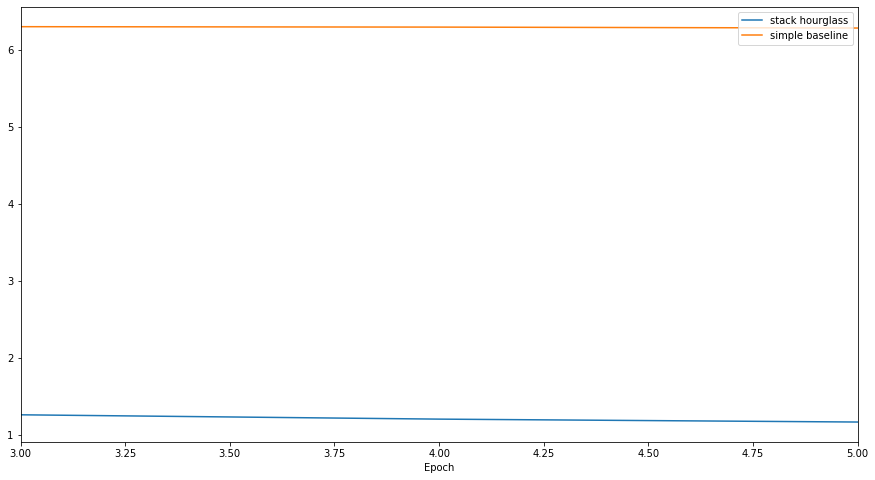

In [38]:
# epoch 3~5 비교
MY_MODELS_PATH = os.path.join(PROJECT_PATH, 'my_models')
total_files = sorted(os.listdir(MY_MODELS_PATH))
for file in total_files:
    print(file)

# 시각화를 위해 앞 3개는 None으로 채움
val_loss_stacked_hourglass = [None, None, None, 1.2638,1.2076,1.1699]
val_loss_simple_base_line = [None, None, None, 6.2991,6.2938,6.2817]

plt.figure(figsize=(15,8))
plt.plot(val_loss_stacked_hourglass, label='stack hourglass')
plt.plot(val_loss_simple_base_line, label='simple baseline')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.xlim([3,5])
plt.show()



# 학습한 모델 가중치 불러오기

In [26]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

## Stacked Hourglass

In [29]:
path_stacked_hourglass = os.path.join(MY_MODELS_PATH, 'my_model-epoch-2+3-loss-1.1699.h5')

model_stacked_hourglass = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model_stacked_hourglass.load_weights(path_stacked_hourglass)

## Simple Baseline

In [30]:
path_simple_baseline = os.path.join(MY_MODELS_PATH, 'simple_baseline-epoch-5-loss-6.2817.h5')

model_simple_baseline = Simplebaseline()
model_simple_baseline.load_weights(path_simple_baseline)

# 결과 시각화

In [31]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [32]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [33]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [34]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

## stacked hourglass(epoch 5)

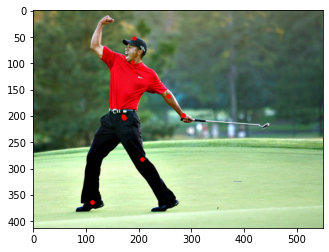

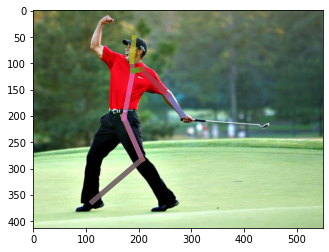

In [39]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model_stacked_hourglass, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

## Simple Baseline(epoch 5)

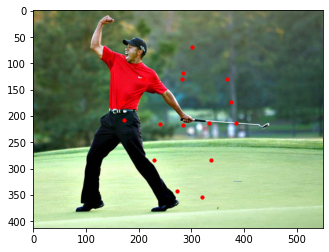

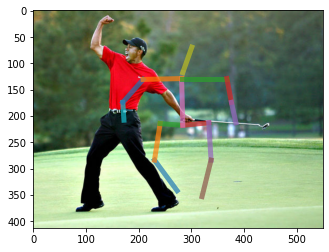

In [40]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model_simple_baseline, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# Simple Baseline 추가학습 (총 epoch 10)
위 5epoch씩 한결과에서는 stacked hourglass 모델이 압도적인 성능을 보여준다... simple baseline을 좀더 train

In [8]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
# epoch 5에서 5번 추가진행
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007
pre_train_path = os.path.join(PROJECT_PATH, 'my_models', 'simple_baseline-epoch-5-loss-6.2817.h5')

train(epochs,
        learning_rate,
        num_heatmap,
        batch_size,
        train_tfrecords,
        val_tfrecords,
        model_type='simple_baseline',
        pre_train_path=pre_train_path,
        start_epoch=5
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 6.18569326 epoch total loss 6.18569326
Trained batch 2 batch loss 6.03332615 epoch total loss 6.10950947
Trained batch 3 batch loss 6.09577 epoch total loss 6.10492945
Trained batch 4 batch loss 6.25585413 epoch total loss 6.14266062
Trained batch 5 batch loss 6.28510141 epoch total loss 6.17114878
Trained batch 6 batch loss 6.27407598 epoch total loss 6.18830299
Trained batch 7 batch loss 6.10184479 epoch total loss 6.17595196
Trained batch 8 batch loss 6.07639933 epoch total loss 6.16350794
Trained batch 9 batch loss 6.23061895 epoch total loss 6.17096472
Trained batch 10 batch loss 6.50693941 epoch total loss 6.20456219
Trained batch 11 batch loss 6.92668915 epoch total loss 6.27021
Trained batch 12 batch loss 5.85230398 epoch total loss 6.23538399
Trained batch 13 batch loss 6.11756325 epoch total loss 6.22632074
Trained batch 14 batch loss 6.63712454 epoch total loss 6.25566387
Trained batch 15 batch loss 6.54218912 epoch t

Trained batch 124 batch loss 6.5571 epoch total loss 6.28637218
Trained batch 125 batch loss 6.78671026 epoch total loss 6.29037428
Trained batch 126 batch loss 6.7726593 epoch total loss 6.29420185
Trained batch 127 batch loss 6.24262142 epoch total loss 6.29379606
Trained batch 128 batch loss 6.21290731 epoch total loss 6.29316378
Trained batch 129 batch loss 6.0584116 epoch total loss 6.29134417
Trained batch 130 batch loss 6.02471876 epoch total loss 6.28929281
Trained batch 131 batch loss 6.17037964 epoch total loss 6.28838491
Trained batch 132 batch loss 6.5747838 epoch total loss 6.29055452
Trained batch 133 batch loss 7.04472542 epoch total loss 6.29622507
Trained batch 134 batch loss 6.94586277 epoch total loss 6.30107307
Trained batch 135 batch loss 6.90713501 epoch total loss 6.30556297
Trained batch 136 batch loss 6.96524429 epoch total loss 6.31041336
Trained batch 137 batch loss 6.74144316 epoch total loss 6.31356
Trained batch 138 batch loss 6.35123682 epoch total loss 6

Trained batch 246 batch loss 6.57287312 epoch total loss 6.32232475
Trained batch 247 batch loss 6.57145405 epoch total loss 6.32333326
Trained batch 248 batch loss 6.32284689 epoch total loss 6.32333136
Trained batch 249 batch loss 6.67906523 epoch total loss 6.32476
Trained batch 250 batch loss 6.37828493 epoch total loss 6.32497406
Trained batch 251 batch loss 6.05197525 epoch total loss 6.32388639
Trained batch 252 batch loss 6.47375 epoch total loss 6.32448149
Trained batch 253 batch loss 6.55910683 epoch total loss 6.32540846
Trained batch 254 batch loss 6.38522768 epoch total loss 6.32564402
Trained batch 255 batch loss 6.1856246 epoch total loss 6.32509518
Trained batch 256 batch loss 6.63294697 epoch total loss 6.32629776
Trained batch 257 batch loss 6.70858526 epoch total loss 6.32778549
Trained batch 258 batch loss 6.77436352 epoch total loss 6.32951641
Trained batch 259 batch loss 6.50602579 epoch total loss 6.33019781
Trained batch 260 batch loss 6.29975796 epoch total los

Trained batch 368 batch loss 6.563797 epoch total loss 6.32988644
Trained batch 369 batch loss 6.45652723 epoch total loss 6.33022976
Trained batch 370 batch loss 6.52818775 epoch total loss 6.33076429
Trained batch 371 batch loss 6.59245539 epoch total loss 6.33147
Trained batch 372 batch loss 6.68435 epoch total loss 6.33241844
Trained batch 373 batch loss 7.36341238 epoch total loss 6.33518267
Trained batch 374 batch loss 7.32902431 epoch total loss 6.33784056
Trained batch 375 batch loss 7.23366785 epoch total loss 6.34022903
Trained batch 376 batch loss 6.56601 epoch total loss 6.34082937
Trained batch 377 batch loss 6.2612772 epoch total loss 6.34061813
Trained batch 378 batch loss 5.67453957 epoch total loss 6.33885622
Trained batch 379 batch loss 6.35208416 epoch total loss 6.33889103
Trained batch 380 batch loss 6.65978575 epoch total loss 6.33973503
Trained batch 381 batch loss 6.92607975 epoch total loss 6.34127378
Trained batch 382 batch loss 6.42338657 epoch total loss 6.3

Trained batch 490 batch loss 5.84912872 epoch total loss 6.31263351
Trained batch 491 batch loss 6.18579912 epoch total loss 6.31237507
Trained batch 492 batch loss 6.23777771 epoch total loss 6.31222343
Trained batch 493 batch loss 6.26490927 epoch total loss 6.31212759
Trained batch 494 batch loss 6.89926863 epoch total loss 6.31331587
Trained batch 495 batch loss 6.58940458 epoch total loss 6.31387377
Trained batch 496 batch loss 7.4984889 epoch total loss 6.31626225
Trained batch 497 batch loss 6.79419327 epoch total loss 6.31722355
Trained batch 498 batch loss 6.5938406 epoch total loss 6.31777906
Trained batch 499 batch loss 6.74745464 epoch total loss 6.31864
Trained batch 500 batch loss 6.57991743 epoch total loss 6.31916237
Trained batch 501 batch loss 6.53224421 epoch total loss 6.31958771
Trained batch 502 batch loss 6.87118673 epoch total loss 6.32068634
Trained batch 503 batch loss 6.44789696 epoch total loss 6.32093954
Trained batch 504 batch loss 6.47820425 epoch total l

Trained batch 612 batch loss 5.74112463 epoch total loss 6.32764769
Trained batch 613 batch loss 5.34042549 epoch total loss 6.32603693
Trained batch 614 batch loss 6.0681963 epoch total loss 6.32561684
Trained batch 615 batch loss 6.74648 epoch total loss 6.3263011
Trained batch 616 batch loss 6.53511 epoch total loss 6.32664
Trained batch 617 batch loss 6.50613165 epoch total loss 6.326931
Trained batch 618 batch loss 6.77692604 epoch total loss 6.32765913
Trained batch 619 batch loss 6.98076105 epoch total loss 6.32871437
Trained batch 620 batch loss 6.55887127 epoch total loss 6.32908535
Trained batch 621 batch loss 6.69056368 epoch total loss 6.32966757
Trained batch 622 batch loss 6.66830158 epoch total loss 6.33021212
Trained batch 623 batch loss 6.04189205 epoch total loss 6.32974911
Trained batch 624 batch loss 6.51052332 epoch total loss 6.33003902
Trained batch 625 batch loss 6.53389215 epoch total loss 6.33036518
Trained batch 626 batch loss 6.67332458 epoch total loss 6.33

Trained batch 734 batch loss 6.29661131 epoch total loss 6.3272109
Trained batch 735 batch loss 6.6163497 epoch total loss 6.32760429
Trained batch 736 batch loss 6.34632254 epoch total loss 6.32762957
Trained batch 737 batch loss 6.28747225 epoch total loss 6.32757521
Trained batch 738 batch loss 6.33398533 epoch total loss 6.32758379
Trained batch 739 batch loss 6.30318832 epoch total loss 6.32755089
Trained batch 740 batch loss 6.31418419 epoch total loss 6.32753229
Trained batch 741 batch loss 6.54322338 epoch total loss 6.32782364
Trained batch 742 batch loss 6.1363821 epoch total loss 6.32756567
Trained batch 743 batch loss 6.19053602 epoch total loss 6.32738113
Trained batch 744 batch loss 6.48729753 epoch total loss 6.32759619
Trained batch 745 batch loss 6.11737251 epoch total loss 6.32731342
Trained batch 746 batch loss 6.53271723 epoch total loss 6.32758904
Trained batch 747 batch loss 6.21017599 epoch total loss 6.32743168
Trained batch 748 batch loss 6.51994038 epoch total

Trained batch 856 batch loss 6.50976706 epoch total loss 6.33043957
Trained batch 857 batch loss 6.5535655 epoch total loss 6.3307004
Trained batch 858 batch loss 6.53815413 epoch total loss 6.33094215
Trained batch 859 batch loss 6.39472198 epoch total loss 6.33101606
Trained batch 860 batch loss 6.54368591 epoch total loss 6.33126307
Trained batch 861 batch loss 6.26227236 epoch total loss 6.33118296
Trained batch 862 batch loss 6.22134829 epoch total loss 6.33105516
Trained batch 863 batch loss 6.35531759 epoch total loss 6.33108377
Trained batch 864 batch loss 6.33769751 epoch total loss 6.3310914
Trained batch 865 batch loss 6.72870874 epoch total loss 6.33155107
Trained batch 866 batch loss 6.1567235 epoch total loss 6.3313489
Trained batch 867 batch loss 6.33765221 epoch total loss 6.33135653
Trained batch 868 batch loss 6.57413626 epoch total loss 6.33163643
Trained batch 869 batch loss 6.28091908 epoch total loss 6.33157778
Trained batch 870 batch loss 6.58583307 epoch total l

Trained batch 978 batch loss 6.21081734 epoch total loss 6.33386087
Trained batch 979 batch loss 6.1315093 epoch total loss 6.3336544
Trained batch 980 batch loss 6.26011 epoch total loss 6.33357906
Trained batch 981 batch loss 6.38110924 epoch total loss 6.33362818
Trained batch 982 batch loss 6.2677536 epoch total loss 6.33356094
Trained batch 983 batch loss 6.47558117 epoch total loss 6.33370543
Trained batch 984 batch loss 6.14708281 epoch total loss 6.33351564
Trained batch 985 batch loss 6.4149 epoch total loss 6.33359814
Trained batch 986 batch loss 5.76124144 epoch total loss 6.33301783
Trained batch 987 batch loss 6.35655975 epoch total loss 6.33304167
Trained batch 988 batch loss 6.294 epoch total loss 6.33300209
Trained batch 989 batch loss 5.74895954 epoch total loss 6.33241129
Trained batch 990 batch loss 6.15194893 epoch total loss 6.33222914
Trained batch 991 batch loss 6.10926342 epoch total loss 6.33200407
Trained batch 992 batch loss 6.2988863 epoch total loss 6.33197

Trained batch 1099 batch loss 6.18017054 epoch total loss 6.32651138
Trained batch 1100 batch loss 6.26030827 epoch total loss 6.3264513
Trained batch 1101 batch loss 6.69791794 epoch total loss 6.32678843
Trained batch 1102 batch loss 6.22258759 epoch total loss 6.32669401
Trained batch 1103 batch loss 6.20575285 epoch total loss 6.32658386
Trained batch 1104 batch loss 6.34933949 epoch total loss 6.32660437
Trained batch 1105 batch loss 6.38082314 epoch total loss 6.32665348
Trained batch 1106 batch loss 6.37091064 epoch total loss 6.32669353
Trained batch 1107 batch loss 6.23844862 epoch total loss 6.3266139
Trained batch 1108 batch loss 5.84381628 epoch total loss 6.32617807
Trained batch 1109 batch loss 6.54621172 epoch total loss 6.32637644
Trained batch 1110 batch loss 5.93027067 epoch total loss 6.32602
Trained batch 1111 batch loss 5.9367733 epoch total loss 6.32567
Trained batch 1112 batch loss 6.23248148 epoch total loss 6.32558584
Trained batch 1113 batch loss 6.22406101 ep

Trained batch 1219 batch loss 6.30118656 epoch total loss 6.33372259
Trained batch 1220 batch loss 6.23829508 epoch total loss 6.33364439
Trained batch 1221 batch loss 6.52369356 epoch total loss 6.33380032
Trained batch 1222 batch loss 5.94814539 epoch total loss 6.33348513
Trained batch 1223 batch loss 6.4304 epoch total loss 6.3335638
Trained batch 1224 batch loss 6.66211319 epoch total loss 6.33383226
Trained batch 1225 batch loss 6.70626402 epoch total loss 6.33413601
Trained batch 1226 batch loss 6.42400217 epoch total loss 6.33420944
Trained batch 1227 batch loss 6.64216805 epoch total loss 6.33446026
Trained batch 1228 batch loss 6.65699768 epoch total loss 6.334723
Trained batch 1229 batch loss 6.74440813 epoch total loss 6.33505678
Trained batch 1230 batch loss 6.44196129 epoch total loss 6.33514357
Trained batch 1231 batch loss 6.49505568 epoch total loss 6.33527327
Trained batch 1232 batch loss 6.65989876 epoch total loss 6.33553696
Trained batch 1233 batch loss 6.88285112 

Trained batch 1339 batch loss 6.25220585 epoch total loss 6.33822823
Trained batch 1340 batch loss 6.36107826 epoch total loss 6.33824539
Trained batch 1341 batch loss 6.18677568 epoch total loss 6.33813238
Trained batch 1342 batch loss 6.24731398 epoch total loss 6.33806467
Trained batch 1343 batch loss 6.33814573 epoch total loss 6.33806419
Trained batch 1344 batch loss 6.09187841 epoch total loss 6.33788109
Trained batch 1345 batch loss 6.42191696 epoch total loss 6.33794355
Trained batch 1346 batch loss 5.91992903 epoch total loss 6.33763313
Trained batch 1347 batch loss 6.20153379 epoch total loss 6.33753157
Trained batch 1348 batch loss 6.40875244 epoch total loss 6.33758497
Trained batch 1349 batch loss 5.86458921 epoch total loss 6.33723402
Trained batch 1350 batch loss 5.77338552 epoch total loss 6.33681631
Trained batch 1351 batch loss 5.72875547 epoch total loss 6.33636618
Trained batch 1352 batch loss 5.68875599 epoch total loss 6.33588696
Trained batch 1353 batch loss 5.82

Validated batch 117 batch loss 6.22486687
Validated batch 118 batch loss 6.14837408
Validated batch 119 batch loss 6.08024406
Validated batch 120 batch loss 6.34101
Validated batch 121 batch loss 6.29263544
Validated batch 122 batch loss 6.32152605
Validated batch 123 batch loss 6.34902191
Validated batch 124 batch loss 6.1427865
Validated batch 125 batch loss 6.37085867
Validated batch 126 batch loss 6.74291945
Validated batch 127 batch loss 6.53730917
Validated batch 128 batch loss 6.18205
Validated batch 129 batch loss 6.22829103
Validated batch 130 batch loss 6.35730934
Validated batch 131 batch loss 6.24704695
Validated batch 132 batch loss 6.61158228
Validated batch 133 batch loss 6.09102869
Validated batch 134 batch loss 6.43668461
Validated batch 135 batch loss 6.23665953
Validated batch 136 batch loss 6.08655357
Validated batch 137 batch loss 6.47852278
Validated batch 138 batch loss 6.39206314
Validated batch 139 batch loss 6.80344152
Validated batch 140 batch loss 6.41640234

Trained batch 79 batch loss 6.48324251 epoch total loss 6.3342
Trained batch 80 batch loss 6.43981218 epoch total loss 6.33552027
Trained batch 81 batch loss 6.8762393 epoch total loss 6.34219551
Trained batch 82 batch loss 6.80537748 epoch total loss 6.34784365
Trained batch 83 batch loss 6.89026546 epoch total loss 6.35437918
Trained batch 84 batch loss 6.52582788 epoch total loss 6.35642
Trained batch 85 batch loss 6.60776138 epoch total loss 6.35937738
Trained batch 86 batch loss 6.95940924 epoch total loss 6.36635447
Trained batch 87 batch loss 6.5878315 epoch total loss 6.3689
Trained batch 88 batch loss 6.41045523 epoch total loss 6.36937237
Trained batch 89 batch loss 6.57875395 epoch total loss 6.37172461
Trained batch 90 batch loss 6.48781824 epoch total loss 6.37301445
Trained batch 91 batch loss 6.62471247 epoch total loss 6.37578
Trained batch 92 batch loss 6.53963852 epoch total loss 6.37756062
Trained batch 93 batch loss 6.45579576 epoch total loss 6.37840223
Trained bat

Trained batch 201 batch loss 6.54358673 epoch total loss 6.32911444
Trained batch 202 batch loss 6.44815302 epoch total loss 6.32970333
Trained batch 203 batch loss 6.63286591 epoch total loss 6.33119678
Trained batch 204 batch loss 6.62673235 epoch total loss 6.33264542
Trained batch 205 batch loss 6.44800472 epoch total loss 6.33320808
Trained batch 206 batch loss 6.42033386 epoch total loss 6.33363056
Trained batch 207 batch loss 6.40007 epoch total loss 6.33395147
Trained batch 208 batch loss 6.38109827 epoch total loss 6.33417797
Trained batch 209 batch loss 6.38609028 epoch total loss 6.3344264
Trained batch 210 batch loss 6.48426199 epoch total loss 6.33513975
Trained batch 211 batch loss 6.37755966 epoch total loss 6.33534098
Trained batch 212 batch loss 6.26436758 epoch total loss 6.33500624
Trained batch 213 batch loss 6.18090916 epoch total loss 6.33428288
Trained batch 214 batch loss 6.54529095 epoch total loss 6.33526897
Trained batch 215 batch loss 6.21922874 epoch total 

Trained batch 323 batch loss 6.26308775 epoch total loss 6.32348156
Trained batch 324 batch loss 6.62119913 epoch total loss 6.32440042
Trained batch 325 batch loss 6.2759676 epoch total loss 6.32425117
Trained batch 326 batch loss 6.64972258 epoch total loss 6.3252492
Trained batch 327 batch loss 6.48921347 epoch total loss 6.32575083
Trained batch 328 batch loss 6.19215488 epoch total loss 6.32534361
Trained batch 329 batch loss 6.12517405 epoch total loss 6.32473516
Trained batch 330 batch loss 6.34964371 epoch total loss 6.3248105
Trained batch 331 batch loss 6.45502329 epoch total loss 6.32520437
Trained batch 332 batch loss 6.63655949 epoch total loss 6.32614183
Trained batch 333 batch loss 6.69522762 epoch total loss 6.32725048
Trained batch 334 batch loss 6.53838062 epoch total loss 6.32788229
Trained batch 335 batch loss 6.57052135 epoch total loss 6.32860661
Trained batch 336 batch loss 6.5675478 epoch total loss 6.32931805
Trained batch 337 batch loss 6.56073046 epoch total 

Trained batch 445 batch loss 6.4628706 epoch total loss 6.33840036
Trained batch 446 batch loss 6.68755722 epoch total loss 6.33918285
Trained batch 447 batch loss 6.61404371 epoch total loss 6.33979797
Trained batch 448 batch loss 6.9749527 epoch total loss 6.34121561
Trained batch 449 batch loss 6.81024742 epoch total loss 6.34226036
Trained batch 450 batch loss 6.96850824 epoch total loss 6.34365177
Trained batch 451 batch loss 7.20195103 epoch total loss 6.34555483
Trained batch 452 batch loss 6.89902449 epoch total loss 6.34677887
Trained batch 453 batch loss 6.80260897 epoch total loss 6.347785
Trained batch 454 batch loss 6.63137674 epoch total loss 6.34840965
Trained batch 455 batch loss 6.39007902 epoch total loss 6.34850121
Trained batch 456 batch loss 6.42259264 epoch total loss 6.34866381
Trained batch 457 batch loss 6.07152557 epoch total loss 6.34805727
Trained batch 458 batch loss 6.20171499 epoch total loss 6.34773779
Trained batch 459 batch loss 5.83468485 epoch total 

Trained batch 567 batch loss 6.11898041 epoch total loss 6.33442
Trained batch 568 batch loss 6.50068712 epoch total loss 6.33471298
Trained batch 569 batch loss 6.33233738 epoch total loss 6.33470869
Trained batch 570 batch loss 6.42399645 epoch total loss 6.33486557
Trained batch 571 batch loss 6.09933519 epoch total loss 6.33445311
Trained batch 572 batch loss 6.1657815 epoch total loss 6.33415794
Trained batch 573 batch loss 6.30732107 epoch total loss 6.33411121
Trained batch 574 batch loss 6.74974442 epoch total loss 6.33483553
Trained batch 575 batch loss 6.83943462 epoch total loss 6.33571291
Trained batch 576 batch loss 6.63942862 epoch total loss 6.33624029
Trained batch 577 batch loss 6.49259043 epoch total loss 6.33651114
Trained batch 578 batch loss 6.79378748 epoch total loss 6.33730221
Trained batch 579 batch loss 6.72017193 epoch total loss 6.33796358
Trained batch 580 batch loss 6.35796499 epoch total loss 6.33799791
Trained batch 581 batch loss 6.85967541 epoch total 

Trained batch 689 batch loss 6.43437719 epoch total loss 6.34543228
Trained batch 690 batch loss 5.88694048 epoch total loss 6.34476757
Trained batch 691 batch loss 6.37504959 epoch total loss 6.34481144
Trained batch 692 batch loss 6.24247169 epoch total loss 6.34466362
Trained batch 693 batch loss 6.24293089 epoch total loss 6.34451723
Trained batch 694 batch loss 6.45354223 epoch total loss 6.34467459
Trained batch 695 batch loss 6.43020582 epoch total loss 6.34479761
Trained batch 696 batch loss 6.34950733 epoch total loss 6.34480429
Trained batch 697 batch loss 6.42285109 epoch total loss 6.34491634
Trained batch 698 batch loss 6.43410778 epoch total loss 6.34504414
Trained batch 699 batch loss 6.4026618 epoch total loss 6.34512663
Trained batch 700 batch loss 6.67739105 epoch total loss 6.34560108
Trained batch 701 batch loss 6.26367331 epoch total loss 6.34548426
Trained batch 702 batch loss 6.44799089 epoch total loss 6.34563
Trained batch 703 batch loss 6.02647114 epoch total 

Trained batch 811 batch loss 6.35070896 epoch total loss 6.34739113
Trained batch 812 batch loss 6.62717581 epoch total loss 6.3477354
Trained batch 813 batch loss 6.27124929 epoch total loss 6.34764194
Trained batch 814 batch loss 6.03834343 epoch total loss 6.34726238
Trained batch 815 batch loss 6.02787447 epoch total loss 6.34687042
Trained batch 816 batch loss 6.14354849 epoch total loss 6.34662104
Trained batch 817 batch loss 6.19776869 epoch total loss 6.34643888
Trained batch 818 batch loss 6.31502438 epoch total loss 6.34640026
Trained batch 819 batch loss 6.86953306 epoch total loss 6.34703922
Trained batch 820 batch loss 6.94042206 epoch total loss 6.34776306
Trained batch 821 batch loss 6.1468749 epoch total loss 6.34751844
Trained batch 822 batch loss 6.23207903 epoch total loss 6.34737778
Trained batch 823 batch loss 5.68374586 epoch total loss 6.34657097
Trained batch 824 batch loss 5.95615339 epoch total loss 6.34609699
Trained batch 825 batch loss 6.32079268 epoch tota

Trained batch 933 batch loss 6.13452435 epoch total loss 6.33899
Trained batch 934 batch loss 6.11757421 epoch total loss 6.33875322
Trained batch 935 batch loss 6.30412054 epoch total loss 6.33871603
Trained batch 936 batch loss 6.33577585 epoch total loss 6.33871317
Trained batch 937 batch loss 6.76213026 epoch total loss 6.33916521
Trained batch 938 batch loss 6.39624405 epoch total loss 6.33922625
Trained batch 939 batch loss 6.43650341 epoch total loss 6.33933
Trained batch 940 batch loss 6.40277815 epoch total loss 6.33939743
Trained batch 941 batch loss 6.66104269 epoch total loss 6.33973932
Trained batch 942 batch loss 6.27006 epoch total loss 6.33966541
Trained batch 943 batch loss 6.2197113 epoch total loss 6.3395381
Trained batch 944 batch loss 6.02059507 epoch total loss 6.3392005
Trained batch 945 batch loss 5.96852398 epoch total loss 6.33880806
Trained batch 946 batch loss 5.4403758 epoch total loss 6.33785868
Trained batch 947 batch loss 5.85061359 epoch total loss 6.33

Trained batch 1054 batch loss 6.10839272 epoch total loss 6.33462667
Trained batch 1055 batch loss 6.14435863 epoch total loss 6.33444643
Trained batch 1056 batch loss 6.16374397 epoch total loss 6.33428431
Trained batch 1057 batch loss 6.26968622 epoch total loss 6.33422327
Trained batch 1058 batch loss 6.2459569 epoch total loss 6.33414
Trained batch 1059 batch loss 6.39079905 epoch total loss 6.33419323
Trained batch 1060 batch loss 6.34821081 epoch total loss 6.33420658
Trained batch 1061 batch loss 6.16371822 epoch total loss 6.33404541
Trained batch 1062 batch loss 6.47349739 epoch total loss 6.33417702
Trained batch 1063 batch loss 6.11853 epoch total loss 6.33397436
Trained batch 1064 batch loss 6.41709757 epoch total loss 6.33405209
Trained batch 1065 batch loss 5.45168924 epoch total loss 6.33322382
Trained batch 1066 batch loss 5.38661623 epoch total loss 6.33233595
Trained batch 1067 batch loss 5.22895145 epoch total loss 6.33130169
Trained batch 1068 batch loss 5.49126673 

Trained batch 1174 batch loss 6.04465723 epoch total loss 6.32392216
Trained batch 1175 batch loss 6.22905 epoch total loss 6.32384157
Trained batch 1176 batch loss 6.42480326 epoch total loss 6.3239274
Trained batch 1177 batch loss 5.78919268 epoch total loss 6.32347298
Trained batch 1178 batch loss 6.24320793 epoch total loss 6.32340479
Trained batch 1179 batch loss 6.08201075 epoch total loss 6.32319975
Trained batch 1180 batch loss 6.36279058 epoch total loss 6.3232336
Trained batch 1181 batch loss 6.21231794 epoch total loss 6.32313967
Trained batch 1182 batch loss 6.54515886 epoch total loss 6.32332706
Trained batch 1183 batch loss 6.3090167 epoch total loss 6.32331514
Trained batch 1184 batch loss 6.46660805 epoch total loss 6.32343626
Trained batch 1185 batch loss 6.64958954 epoch total loss 6.3237114
Trained batch 1186 batch loss 6.39958191 epoch total loss 6.32377529
Trained batch 1187 batch loss 6.1278224 epoch total loss 6.32361031
Trained batch 1188 batch loss 6.41017199 e

Trained batch 1294 batch loss 6.58420134 epoch total loss 6.32216644
Trained batch 1295 batch loss 6.24892378 epoch total loss 6.3221097
Trained batch 1296 batch loss 6.43586397 epoch total loss 6.32219791
Trained batch 1297 batch loss 6.53591156 epoch total loss 6.3223629
Trained batch 1298 batch loss 6.64673185 epoch total loss 6.32261229
Trained batch 1299 batch loss 6.34212875 epoch total loss 6.32262707
Trained batch 1300 batch loss 6.24830818 epoch total loss 6.32257
Trained batch 1301 batch loss 6.4973588 epoch total loss 6.32270384
Trained batch 1302 batch loss 6.48160315 epoch total loss 6.32282591
Trained batch 1303 batch loss 6.22736549 epoch total loss 6.32275295
Trained batch 1304 batch loss 6.33289766 epoch total loss 6.32276058
Trained batch 1305 batch loss 6.33655548 epoch total loss 6.32277155
Trained batch 1306 batch loss 6.53240395 epoch total loss 6.32293177
Trained batch 1307 batch loss 6.50529051 epoch total loss 6.323071
Trained batch 1308 batch loss 6.09503508 e

Validated batch 42 batch loss 6.26488161
Validated batch 43 batch loss 6.14669704
Validated batch 44 batch loss 6.58497047
Validated batch 45 batch loss 5.45286846
Validated batch 46 batch loss 6.74507618
Validated batch 47 batch loss 6.39450693
Validated batch 48 batch loss 6.28696728
Validated batch 49 batch loss 6.06696796
Validated batch 50 batch loss 6.12877893
Validated batch 51 batch loss 6.46995926
Validated batch 52 batch loss 6.26105833
Validated batch 53 batch loss 6.37170124
Validated batch 54 batch loss 6.1776104
Validated batch 55 batch loss 6.19838238
Validated batch 56 batch loss 6.59108734
Validated batch 57 batch loss 6.66010237
Validated batch 58 batch loss 6.39768505
Validated batch 59 batch loss 6.35006046
Validated batch 60 batch loss 6.20389223
Validated batch 61 batch loss 6.38711548
Validated batch 62 batch loss 6.29747677
Validated batch 63 batch loss 6.50831938
Validated batch 64 batch loss 6.26965618
Validated batch 65 batch loss 6.03866482
Validated batch 6

Trained batch 32 batch loss 6.16125154 epoch total loss 6.27519941
Trained batch 33 batch loss 6.24928761 epoch total loss 6.27441406
Trained batch 34 batch loss 6.15180779 epoch total loss 6.27080822
Trained batch 35 batch loss 6.00649071 epoch total loss 6.26325607
Trained batch 36 batch loss 6.39221239 epoch total loss 6.26683807
Trained batch 37 batch loss 6.36244249 epoch total loss 6.26942205
Trained batch 38 batch loss 6.11975574 epoch total loss 6.26548338
Trained batch 39 batch loss 6.37197351 epoch total loss 6.26821375
Trained batch 40 batch loss 6.20575571 epoch total loss 6.26665211
Trained batch 41 batch loss 6.2820158 epoch total loss 6.26702738
Trained batch 42 batch loss 6.05132151 epoch total loss 6.26189184
Trained batch 43 batch loss 6.39461946 epoch total loss 6.26497841
Trained batch 44 batch loss 6.13553619 epoch total loss 6.26203632
Trained batch 45 batch loss 6.14150524 epoch total loss 6.25935793
Trained batch 46 batch loss 6.22573471 epoch total loss 6.25862

Trained batch 155 batch loss 6.599 epoch total loss 6.35041475
Trained batch 156 batch loss 6.2890377 epoch total loss 6.35002136
Trained batch 157 batch loss 6.2055912 epoch total loss 6.34910107
Trained batch 158 batch loss 6.31599 epoch total loss 6.34889174
Trained batch 159 batch loss 6.41313648 epoch total loss 6.34929562
Trained batch 160 batch loss 6.62692547 epoch total loss 6.3510313
Trained batch 161 batch loss 6.65571165 epoch total loss 6.35292339
Trained batch 162 batch loss 6.86224413 epoch total loss 6.35606766
Trained batch 163 batch loss 6.25604677 epoch total loss 6.35545444
Trained batch 164 batch loss 6.35832405 epoch total loss 6.35547161
Trained batch 165 batch loss 6.32071257 epoch total loss 6.35526085
Trained batch 166 batch loss 6.16394281 epoch total loss 6.35410833
Trained batch 167 batch loss 6.32091713 epoch total loss 6.35390949
Trained batch 168 batch loss 6.90928745 epoch total loss 6.3572154
Trained batch 169 batch loss 6.60273457 epoch total loss 6.3

Trained batch 277 batch loss 6.92752361 epoch total loss 6.35927248
Trained batch 278 batch loss 7.24967337 epoch total loss 6.36247492
Trained batch 279 batch loss 7.25478888 epoch total loss 6.36567307
Trained batch 280 batch loss 7.3948164 epoch total loss 6.36934853
Trained batch 281 batch loss 6.39969063 epoch total loss 6.36945629
Trained batch 282 batch loss 6.5117116 epoch total loss 6.36996078
Trained batch 283 batch loss 6.39160776 epoch total loss 6.37003756
Trained batch 284 batch loss 6.20693684 epoch total loss 6.36946297
Trained batch 285 batch loss 6.26037121 epoch total loss 6.36908
Trained batch 286 batch loss 6.31995726 epoch total loss 6.36890841
Trained batch 287 batch loss 6.03577423 epoch total loss 6.36774778
Trained batch 288 batch loss 5.90325832 epoch total loss 6.36613464
Trained batch 289 batch loss 6.0880661 epoch total loss 6.36517239
Trained batch 290 batch loss 6.33956337 epoch total loss 6.36508417
Trained batch 291 batch loss 6.2507391 epoch total los

Trained batch 399 batch loss 6.38987398 epoch total loss 6.36533976
Trained batch 400 batch loss 6.38239861 epoch total loss 6.36538219
Trained batch 401 batch loss 6.04438925 epoch total loss 6.36458158
Trained batch 402 batch loss 6.26494598 epoch total loss 6.36433363
Trained batch 403 batch loss 6.09096575 epoch total loss 6.36365557
Trained batch 404 batch loss 6.10428667 epoch total loss 6.36301374
Trained batch 405 batch loss 6.10687637 epoch total loss 6.36238146
Trained batch 406 batch loss 6.18178701 epoch total loss 6.36193657
Trained batch 407 batch loss 6.18210363 epoch total loss 6.36149502
Trained batch 408 batch loss 6.22283602 epoch total loss 6.36115503
Trained batch 409 batch loss 6.28968096 epoch total loss 6.36098051
Trained batch 410 batch loss 6.31767464 epoch total loss 6.36087513
Trained batch 411 batch loss 6.17385435 epoch total loss 6.36041975
Trained batch 412 batch loss 5.86512947 epoch total loss 6.35921812
Trained batch 413 batch loss 6.32497311 epoch to

Trained batch 751 batch loss 6.33583164 epoch total loss 6.31207943
Trained batch 752 batch loss 6.39331579 epoch total loss 6.31218767
Trained batch 753 batch loss 6.70966387 epoch total loss 6.31271505
Trained batch 754 batch loss 6.70705223 epoch total loss 6.31323814
Trained batch 755 batch loss 6.22596264 epoch total loss 6.31312275
Trained batch 756 batch loss 6.47750378 epoch total loss 6.31334
Trained batch 757 batch loss 6.37283707 epoch total loss 6.31341934
Trained batch 758 batch loss 6.16144371 epoch total loss 6.31321907
Trained batch 759 batch loss 6.25571346 epoch total loss 6.31314325
Trained batch 760 batch loss 6.42008162 epoch total loss 6.31328392
Trained batch 761 batch loss 6.24804783 epoch total loss 6.31319809
Trained batch 762 batch loss 6.40138102 epoch total loss 6.31331396
Trained batch 763 batch loss 6.25793171 epoch total loss 6.313241
Trained batch 764 batch loss 6.67886114 epoch total loss 6.31371927
Trained batch 765 batch loss 6.62204 epoch total loss

Trained batch 873 batch loss 5.84687328 epoch total loss 6.31663227
Trained batch 874 batch loss 6.06057644 epoch total loss 6.31633902
Trained batch 875 batch loss 5.98074293 epoch total loss 6.31595612
Trained batch 876 batch loss 6.26351833 epoch total loss 6.31589603
Trained batch 877 batch loss 5.79670334 epoch total loss 6.31530428
Trained batch 878 batch loss 6.40157461 epoch total loss 6.31540251
Trained batch 879 batch loss 6.28041887 epoch total loss 6.31536245
Trained batch 880 batch loss 6.40641069 epoch total loss 6.31546593
Trained batch 881 batch loss 6.50338411 epoch total loss 6.31567907
Trained batch 882 batch loss 6.08784246 epoch total loss 6.31542063
Trained batch 883 batch loss 5.11930037 epoch total loss 6.31406593
Trained batch 884 batch loss 4.97609949 epoch total loss 6.31255245
Trained batch 885 batch loss 5.8853159 epoch total loss 6.31206942
Trained batch 886 batch loss 6.74591351 epoch total loss 6.3125596
Trained batch 887 batch loss 7.0358963 epoch total

Trained batch 995 batch loss 6.51996756 epoch total loss 6.30194235
Trained batch 996 batch loss 6.59362221 epoch total loss 6.30223513
Trained batch 997 batch loss 6.45773125 epoch total loss 6.30239105
Trained batch 998 batch loss 6.24937868 epoch total loss 6.30233812
Trained batch 999 batch loss 6.3521347 epoch total loss 6.30238771
Trained batch 1000 batch loss 6.40484428 epoch total loss 6.30249
Trained batch 1001 batch loss 6.54595184 epoch total loss 6.30273342
Trained batch 1002 batch loss 6.45462561 epoch total loss 6.30288506
Trained batch 1003 batch loss 6.49589109 epoch total loss 6.3030777
Trained batch 1004 batch loss 6.20655203 epoch total loss 6.30298138
Trained batch 1005 batch loss 6.58946466 epoch total loss 6.30326653
Trained batch 1006 batch loss 6.44542933 epoch total loss 6.30340767
Trained batch 1007 batch loss 6.48446274 epoch total loss 6.30358744
Trained batch 1008 batch loss 6.68164635 epoch total loss 6.30396223
Trained batch 1009 batch loss 6.79260445 epo

Trained batch 1115 batch loss 5.99185276 epoch total loss 6.31719542
Trained batch 1116 batch loss 6.05919552 epoch total loss 6.31696415
Trained batch 1117 batch loss 6.40838718 epoch total loss 6.31704569
Trained batch 1118 batch loss 6.31082249 epoch total loss 6.31704044
Trained batch 1119 batch loss 6.1891818 epoch total loss 6.316926
Trained batch 1120 batch loss 6.59812212 epoch total loss 6.31717682
Trained batch 1121 batch loss 6.34386635 epoch total loss 6.31720066
Trained batch 1122 batch loss 6.87861347 epoch total loss 6.31770086
Trained batch 1123 batch loss 5.72810078 epoch total loss 6.31717587
Trained batch 1124 batch loss 5.98840237 epoch total loss 6.31688309
Trained batch 1125 batch loss 6.17672348 epoch total loss 6.31675863
Trained batch 1126 batch loss 6.45331669 epoch total loss 6.31687975
Trained batch 1127 batch loss 6.38900757 epoch total loss 6.31694412
Trained batch 1128 batch loss 6.19579268 epoch total loss 6.31683636
Trained batch 1129 batch loss 5.55371

Validated batch 124 batch loss 6.13531446
Validated batch 125 batch loss 6.36696243
Validated batch 126 batch loss 6.4982276
Validated batch 127 batch loss 5.97908831
Validated batch 128 batch loss 5.46482038
Validated batch 129 batch loss 6.58937788
Validated batch 130 batch loss 6.47169256
Validated batch 131 batch loss 6.3184123
Validated batch 132 batch loss 6.33909512
Validated batch 133 batch loss 6.53124237
Validated batch 134 batch loss 6.49364328
Validated batch 135 batch loss 6.57215595
Validated batch 136 batch loss 6.42604685
Validated batch 137 batch loss 6.43744087
Validated batch 138 batch loss 5.81421375
Validated batch 139 batch loss 6.27592754
Validated batch 140 batch loss 6.77004051
Validated batch 141 batch loss 6.32246208
Validated batch 142 batch loss 5.75490665
Validated batch 143 batch loss 6.29532909
Validated batch 144 batch loss 6.18083954
Validated batch 145 batch loss 5.87004757
Validated batch 146 batch loss 6.07561
Validated batch 147 batch loss 5.804811

Trained batch 83 batch loss 6.30563641 epoch total loss 6.17270613
Trained batch 84 batch loss 6.58979082 epoch total loss 6.17767096
Trained batch 85 batch loss 6.88476658 epoch total loss 6.18599
Trained batch 86 batch loss 6.6719017 epoch total loss 6.19164
Trained batch 87 batch loss 6.80870581 epoch total loss 6.19873238
Trained batch 88 batch loss 6.06840897 epoch total loss 6.1972518
Trained batch 89 batch loss 5.89049482 epoch total loss 6.19380522
Trained batch 90 batch loss 5.78306341 epoch total loss 6.18924141
Trained batch 91 batch loss 5.84109735 epoch total loss 6.18541622
Trained batch 92 batch loss 6.01753855 epoch total loss 6.18359089
Trained batch 93 batch loss 7.08815861 epoch total loss 6.19331741
Trained batch 94 batch loss 6.72021198 epoch total loss 6.19892263
Trained batch 95 batch loss 6.91251183 epoch total loss 6.20643425
Trained batch 96 batch loss 6.64696455 epoch total loss 6.21102333
Trained batch 97 batch loss 6.96891308 epoch total loss 6.21883678
Tra

Trained batch 205 batch loss 6.56959534 epoch total loss 6.28665733
Trained batch 206 batch loss 6.38976908 epoch total loss 6.28715801
Trained batch 207 batch loss 6.36306047 epoch total loss 6.2875247
Trained batch 208 batch loss 6.41724205 epoch total loss 6.28814793
Trained batch 209 batch loss 6.33876705 epoch total loss 6.28839
Trained batch 210 batch loss 6.41475296 epoch total loss 6.28899193
Trained batch 211 batch loss 6.34850311 epoch total loss 6.28927422
Trained batch 212 batch loss 6.39565849 epoch total loss 6.28977585
Trained batch 213 batch loss 6.19585896 epoch total loss 6.28933477
Trained batch 214 batch loss 6.46945047 epoch total loss 6.29017639
Trained batch 215 batch loss 6.41744089 epoch total loss 6.29076862
Trained batch 216 batch loss 6.26473045 epoch total loss 6.29064846
Trained batch 217 batch loss 6.39262 epoch total loss 6.29111814
Trained batch 218 batch loss 5.60382414 epoch total loss 6.28796577
Trained batch 219 batch loss 6.15910769 epoch total los

Trained batch 327 batch loss 5.83684444 epoch total loss 6.29294491
Trained batch 328 batch loss 5.88790226 epoch total loss 6.29171
Trained batch 329 batch loss 6.44716501 epoch total loss 6.29218292
Trained batch 330 batch loss 6.17971134 epoch total loss 6.29184198
Trained batch 331 batch loss 6.34746456 epoch total loss 6.29201
Trained batch 332 batch loss 6.42585182 epoch total loss 6.29241276
Trained batch 333 batch loss 6.3520937 epoch total loss 6.29259205
Trained batch 334 batch loss 6.48145771 epoch total loss 6.2931571
Trained batch 335 batch loss 6.44544077 epoch total loss 6.29361248
Trained batch 336 batch loss 6.37915087 epoch total loss 6.29386663
Trained batch 337 batch loss 6.10100317 epoch total loss 6.29329491
Trained batch 338 batch loss 6.32999945 epoch total loss 6.29340363
Trained batch 339 batch loss 6.55723953 epoch total loss 6.29418135
Trained batch 340 batch loss 6.6079812 epoch total loss 6.29510403
Trained batch 341 batch loss 6.42105722 epoch total loss 

Trained batch 449 batch loss 5.34383345 epoch total loss 6.27879953
Trained batch 450 batch loss 4.59309864 epoch total loss 6.27505302
Trained batch 451 batch loss 5.51048613 epoch total loss 6.27335787
Trained batch 452 batch loss 6.7283268 epoch total loss 6.27436447
Trained batch 453 batch loss 7.19986963 epoch total loss 6.27640772
Trained batch 454 batch loss 7.06020164 epoch total loss 6.27813435
Trained batch 455 batch loss 6.70524836 epoch total loss 6.27907324
Trained batch 456 batch loss 6.6709919 epoch total loss 6.2799325
Trained batch 457 batch loss 6.36881447 epoch total loss 6.28012705
Trained batch 458 batch loss 6.0472374 epoch total loss 6.27961826
Trained batch 459 batch loss 6.55646896 epoch total loss 6.28022146
Trained batch 460 batch loss 6.3303051 epoch total loss 6.28033
Trained batch 461 batch loss 6.54258728 epoch total loss 6.28089905
Trained batch 462 batch loss 6.60203171 epoch total loss 6.2815938
Trained batch 463 batch loss 6.1970005 epoch total loss 6

Trained batch 571 batch loss 6.21073103 epoch total loss 6.30336428
Trained batch 572 batch loss 6.58492136 epoch total loss 6.30385637
Trained batch 573 batch loss 6.56242704 epoch total loss 6.30430794
Trained batch 574 batch loss 6.33997059 epoch total loss 6.3043704
Trained batch 575 batch loss 6.4065156 epoch total loss 6.30454779
Trained batch 576 batch loss 5.44672775 epoch total loss 6.30305862
Trained batch 577 batch loss 5.42815971 epoch total loss 6.30154228
Trained batch 578 batch loss 5.55015039 epoch total loss 6.30024242
Trained batch 579 batch loss 6.05521154 epoch total loss 6.29981899
Trained batch 580 batch loss 6.09526062 epoch total loss 6.29946613
Trained batch 581 batch loss 6.07308483 epoch total loss 6.29907656
Trained batch 582 batch loss 5.9184289 epoch total loss 6.29842234
Trained batch 583 batch loss 5.94848919 epoch total loss 6.29782248
Trained batch 584 batch loss 5.92217207 epoch total loss 6.29717875
Trained batch 585 batch loss 5.82782364 epoch total

Trained batch 693 batch loss 6.03158951 epoch total loss 6.30785
Trained batch 694 batch loss 6.16175079 epoch total loss 6.30763912
Trained batch 695 batch loss 6.24530077 epoch total loss 6.307549
Trained batch 696 batch loss 6.18504953 epoch total loss 6.30737305
Trained batch 697 batch loss 6.28056049 epoch total loss 6.3073349
Trained batch 698 batch loss 5.99843788 epoch total loss 6.3068924
Trained batch 699 batch loss 6.17090225 epoch total loss 6.30669785
Trained batch 700 batch loss 6.49865103 epoch total loss 6.30697203
Trained batch 701 batch loss 6.70739889 epoch total loss 6.30754328
Trained batch 702 batch loss 6.54755402 epoch total loss 6.30788517
Trained batch 703 batch loss 6.58207083 epoch total loss 6.30827475
Trained batch 704 batch loss 6.35473251 epoch total loss 6.30834055
Trained batch 705 batch loss 6.6138463 epoch total loss 6.30877399
Trained batch 706 batch loss 6.2902751 epoch total loss 6.30874729
Trained batch 707 batch loss 6.6503334 epoch total loss 6

Trained batch 815 batch loss 6.1519 epoch total loss 6.32527161
Trained batch 816 batch loss 6.0745554 epoch total loss 6.32496452
Trained batch 817 batch loss 6.48280907 epoch total loss 6.32515764
Trained batch 818 batch loss 6.61362123 epoch total loss 6.3255105
Trained batch 819 batch loss 6.71926117 epoch total loss 6.32599115
Trained batch 820 batch loss 6.53528118 epoch total loss 6.32624626
Trained batch 821 batch loss 6.43000698 epoch total loss 6.3263731
Trained batch 822 batch loss 6.2819066 epoch total loss 6.32631874
Trained batch 823 batch loss 6.08296776 epoch total loss 6.3260231
Trained batch 824 batch loss 6.49166059 epoch total loss 6.32622385
Trained batch 825 batch loss 6.37610674 epoch total loss 6.32628441
Trained batch 826 batch loss 6.29344177 epoch total loss 6.32624435
Trained batch 827 batch loss 6.50178909 epoch total loss 6.32645702
Trained batch 828 batch loss 6.31561947 epoch total loss 6.32644367
Trained batch 829 batch loss 5.7308445 epoch total loss 6

Trained batch 937 batch loss 6.329597 epoch total loss 6.31043673
Trained batch 938 batch loss 6.30589962 epoch total loss 6.31043196
Trained batch 939 batch loss 6.49552727 epoch total loss 6.31062889
Trained batch 940 batch loss 6.49261189 epoch total loss 6.31082249
Trained batch 941 batch loss 6.5248332 epoch total loss 6.31105042
Trained batch 942 batch loss 6.98732948 epoch total loss 6.31176805
Trained batch 943 batch loss 6.80364561 epoch total loss 6.31228971
Trained batch 944 batch loss 6.69975138 epoch total loss 6.31270027
Trained batch 945 batch loss 6.56980181 epoch total loss 6.31297207
Trained batch 946 batch loss 6.63485718 epoch total loss 6.31331253
Trained batch 947 batch loss 6.09337664 epoch total loss 6.31308
Trained batch 948 batch loss 6.33045292 epoch total loss 6.31309843
Trained batch 949 batch loss 6.77850151 epoch total loss 6.31358862
Trained batch 950 batch loss 6.4227109 epoch total loss 6.31370354
Trained batch 951 batch loss 6.57137108 epoch total los

Trained batch 1058 batch loss 6.12721348 epoch total loss 6.32163239
Trained batch 1059 batch loss 6.21629572 epoch total loss 6.3215332
Trained batch 1060 batch loss 6.3132019 epoch total loss 6.3215251
Trained batch 1061 batch loss 6.17735386 epoch total loss 6.32138872
Trained batch 1062 batch loss 6.13712883 epoch total loss 6.32121563
Trained batch 1063 batch loss 6.18758202 epoch total loss 6.32108974
Trained batch 1064 batch loss 5.64365578 epoch total loss 6.32045269
Trained batch 1065 batch loss 6.18192959 epoch total loss 6.32032299
Trained batch 1066 batch loss 6.13130856 epoch total loss 6.32014561
Trained batch 1067 batch loss 6.52058125 epoch total loss 6.32033348
Trained batch 1068 batch loss 6.49711704 epoch total loss 6.32049894
Trained batch 1069 batch loss 6.6426692 epoch total loss 6.3208003
Trained batch 1070 batch loss 5.98925686 epoch total loss 6.32049036
Trained batch 1071 batch loss 6.30680323 epoch total loss 6.32047749
Trained batch 1072 batch loss 5.8200373

Trained batch 1178 batch loss 6.3569479 epoch total loss 6.31695
Trained batch 1179 batch loss 6.24677944 epoch total loss 6.31689024
Trained batch 1180 batch loss 6.16266108 epoch total loss 6.31675959
Trained batch 1181 batch loss 6.06918287 epoch total loss 6.31655025
Trained batch 1182 batch loss 6.53908348 epoch total loss 6.31673861
Trained batch 1183 batch loss 6.57283592 epoch total loss 6.31695461
Trained batch 1184 batch loss 6.75125408 epoch total loss 6.31732178
Trained batch 1185 batch loss 6.75122213 epoch total loss 6.31768799
Trained batch 1186 batch loss 6.72709894 epoch total loss 6.31803322
Trained batch 1187 batch loss 7.11410522 epoch total loss 6.31870413
Trained batch 1188 batch loss 6.87662792 epoch total loss 6.31917381
Trained batch 1189 batch loss 7.34488344 epoch total loss 6.32003593
Trained batch 1190 batch loss 6.96504354 epoch total loss 6.3205781
Trained batch 1191 batch loss 6.65216589 epoch total loss 6.32085657
Trained batch 1192 batch loss 6.4348826

Trained batch 1298 batch loss 6.03566837 epoch total loss 6.31717682
Trained batch 1299 batch loss 6.06365967 epoch total loss 6.31698132
Trained batch 1300 batch loss 5.88114834 epoch total loss 6.3166461
Trained batch 1301 batch loss 6.43785143 epoch total loss 6.31673861
Trained batch 1302 batch loss 6.44745874 epoch total loss 6.31683922
Trained batch 1303 batch loss 6.11855793 epoch total loss 6.31668663
Trained batch 1304 batch loss 6.22972584 epoch total loss 6.31662
Trained batch 1305 batch loss 6.248 epoch total loss 6.31656694
Trained batch 1306 batch loss 6.29791975 epoch total loss 6.31655264
Trained batch 1307 batch loss 6.29843187 epoch total loss 6.31653929
Trained batch 1308 batch loss 6.42366076 epoch total loss 6.3166213
Trained batch 1309 batch loss 6.23436975 epoch total loss 6.31655836
Trained batch 1310 batch loss 6.24195528 epoch total loss 6.31650162
Trained batch 1311 batch loss 5.93050098 epoch total loss 6.31620741
Trained batch 1312 batch loss 6.07274485 epo

Validated batch 49 batch loss 6.42347717
Validated batch 50 batch loss 6.26034
Validated batch 51 batch loss 6.34796906
Validated batch 52 batch loss 6.44898224
Validated batch 53 batch loss 6.35648537
Validated batch 54 batch loss 5.95591831
Validated batch 55 batch loss 6.25386715
Validated batch 56 batch loss 6.19043541
Validated batch 57 batch loss 6.32865667
Validated batch 58 batch loss 6.1241312
Validated batch 59 batch loss 6.15854549
Validated batch 60 batch loss 5.99807596
Validated batch 61 batch loss 6.27934074
Validated batch 62 batch loss 6.43534088
Validated batch 63 batch loss 6.51952171
Validated batch 64 batch loss 6.58057356
Validated batch 65 batch loss 6.92590332
Validated batch 66 batch loss 7.22078705
Validated batch 67 batch loss 6.70950079
Validated batch 68 batch loss 6.35726166
Validated batch 69 batch loss 5.92522335
Validated batch 70 batch loss 6.06672955
Validated batch 71 batch loss 6.4199748
Validated batch 72 batch loss 6.02890682
Validated batch 73 ba

Trained batch 36 batch loss 5.92223 epoch total loss 6.15085745
Trained batch 37 batch loss 6.01056671 epoch total loss 6.14706564
Trained batch 38 batch loss 6.35828876 epoch total loss 6.15262461
Trained batch 39 batch loss 6.15655613 epoch total loss 6.15272522
Trained batch 40 batch loss 6.24578714 epoch total loss 6.15505171
Trained batch 41 batch loss 6.78056145 epoch total loss 6.17030811
Trained batch 42 batch loss 6.99300241 epoch total loss 6.18989658
Trained batch 43 batch loss 7.13033104 epoch total loss 6.2117672
Trained batch 44 batch loss 6.52735424 epoch total loss 6.2189393
Trained batch 45 batch loss 6.59622717 epoch total loss 6.22732353
Trained batch 46 batch loss 6.42276478 epoch total loss 6.23157215
Trained batch 47 batch loss 7.18575621 epoch total loss 6.25187397
Trained batch 48 batch loss 7.20561266 epoch total loss 6.27174377
Trained batch 49 batch loss 6.78376293 epoch total loss 6.28219271
Trained batch 50 batch loss 6.80001497 epoch total loss 6.29254961


Trained batch 159 batch loss 6.54664469 epoch total loss 6.32620239
Trained batch 160 batch loss 6.50229 epoch total loss 6.32730293
Trained batch 161 batch loss 6.32301 epoch total loss 6.32727623
Trained batch 162 batch loss 6.60338163 epoch total loss 6.32898045
Trained batch 163 batch loss 6.91261816 epoch total loss 6.33256054
Trained batch 164 batch loss 6.6306982 epoch total loss 6.33437872
Trained batch 165 batch loss 6.76247072 epoch total loss 6.33697319
Trained batch 166 batch loss 6.8303113 epoch total loss 6.33994532
Trained batch 167 batch loss 6.69754648 epoch total loss 6.34208632
Trained batch 168 batch loss 6.90374565 epoch total loss 6.34542942
Trained batch 169 batch loss 6.57865334 epoch total loss 6.34680891
Trained batch 170 batch loss 6.71402836 epoch total loss 6.34896898
Trained batch 171 batch loss 6.62090874 epoch total loss 6.35055876
Trained batch 172 batch loss 6.38060284 epoch total loss 6.35073376
Trained batch 173 batch loss 6.29794264 epoch total loss

Trained batch 281 batch loss 6.15271807 epoch total loss 6.35595
Trained batch 282 batch loss 6.43448591 epoch total loss 6.35622787
Trained batch 283 batch loss 6.49563503 epoch total loss 6.35672045
Trained batch 284 batch loss 6.45296526 epoch total loss 6.35705948
Trained batch 285 batch loss 6.6046133 epoch total loss 6.35792828
Trained batch 286 batch loss 6.30858564 epoch total loss 6.35775566
Trained batch 287 batch loss 6.34185028 epoch total loss 6.3577
Trained batch 288 batch loss 6.53013706 epoch total loss 6.35829878
Trained batch 289 batch loss 6.36575222 epoch total loss 6.35832453
Trained batch 290 batch loss 6.27228832 epoch total loss 6.35802794
Trained batch 291 batch loss 5.718225 epoch total loss 6.35582972
Trained batch 292 batch loss 5.70085669 epoch total loss 6.3535862
Trained batch 293 batch loss 5.44938564 epoch total loss 6.3505
Trained batch 294 batch loss 5.54115438 epoch total loss 6.34774733
Trained batch 295 batch loss 5.43649483 epoch total loss 6.3446

Trained batch 403 batch loss 6.57327414 epoch total loss 6.35189581
Trained batch 404 batch loss 6.39728308 epoch total loss 6.35200787
Trained batch 405 batch loss 5.49059582 epoch total loss 6.3498807
Trained batch 406 batch loss 5.30027914 epoch total loss 6.34729528
Trained batch 407 batch loss 6.75890493 epoch total loss 6.34830666
Trained batch 408 batch loss 6.5563364 epoch total loss 6.34881639
Trained batch 409 batch loss 5.98905516 epoch total loss 6.34793663
Trained batch 410 batch loss 6.32817221 epoch total loss 6.34788847
Trained batch 411 batch loss 6.51216459 epoch total loss 6.34828806
Trained batch 412 batch loss 6.13938046 epoch total loss 6.34778118
Trained batch 413 batch loss 6.28724766 epoch total loss 6.34763479
Trained batch 414 batch loss 6.03110743 epoch total loss 6.34687
Trained batch 415 batch loss 6.5247736 epoch total loss 6.34729862
Trained batch 416 batch loss 6.35849047 epoch total loss 6.34732533
Trained batch 417 batch loss 6.53910828 epoch total lo

Trained batch 525 batch loss 6.70516968 epoch total loss 6.34825182
Trained batch 526 batch loss 6.75867462 epoch total loss 6.3490324
Trained batch 527 batch loss 6.89819336 epoch total loss 6.35007429
Trained batch 528 batch loss 6.38080931 epoch total loss 6.35013294
Trained batch 529 batch loss 5.95605373 epoch total loss 6.34938765
Trained batch 530 batch loss 6.34710121 epoch total loss 6.34938383
Trained batch 531 batch loss 6.46111774 epoch total loss 6.34959412
Trained batch 532 batch loss 6.20875072 epoch total loss 6.34932947
Trained batch 533 batch loss 6.32136488 epoch total loss 6.34927702
Trained batch 534 batch loss 6.24491549 epoch total loss 6.34908152
Trained batch 535 batch loss 5.96391964 epoch total loss 6.34836149
Trained batch 536 batch loss 6.12191105 epoch total loss 6.34793854
Trained batch 537 batch loss 6.25736189 epoch total loss 6.34776974
Trained batch 538 batch loss 6.03223276 epoch total loss 6.34718323
Trained batch 539 batch loss 6.27114487 epoch tot

Trained batch 647 batch loss 5.60710907 epoch total loss 6.35789871
Trained batch 648 batch loss 5.97159147 epoch total loss 6.35730267
Trained batch 649 batch loss 5.82375574 epoch total loss 6.3564806
Trained batch 650 batch loss 6.17180681 epoch total loss 6.35619688
Trained batch 651 batch loss 6.64697695 epoch total loss 6.3566432
Trained batch 652 batch loss 5.88278532 epoch total loss 6.3559165
Trained batch 653 batch loss 6.14947891 epoch total loss 6.35560036
Trained batch 654 batch loss 6.11380672 epoch total loss 6.35523081
Trained batch 655 batch loss 5.88194799 epoch total loss 6.35450792
Trained batch 656 batch loss 6.03112268 epoch total loss 6.35401487
Trained batch 657 batch loss 6.05698204 epoch total loss 6.35356331
Trained batch 658 batch loss 5.53864527 epoch total loss 6.35232449
Trained batch 659 batch loss 5.44258356 epoch total loss 6.35094404
Trained batch 660 batch loss 5.44367552 epoch total loss 6.34956932
Trained batch 661 batch loss 5.6942029 epoch total 

Trained batch 769 batch loss 6.1282897 epoch total loss 6.3410387
Trained batch 770 batch loss 6.02276325 epoch total loss 6.34062576
Trained batch 771 batch loss 6.43918371 epoch total loss 6.34075308
Trained batch 772 batch loss 6.38814116 epoch total loss 6.34081459
Trained batch 773 batch loss 6.70328426 epoch total loss 6.34128332
Trained batch 774 batch loss 6.73651 epoch total loss 6.34179354
Trained batch 775 batch loss 6.74808168 epoch total loss 6.34231806
Trained batch 776 batch loss 6.80196714 epoch total loss 6.34291
Trained batch 777 batch loss 6.47608805 epoch total loss 6.34308147
Trained batch 778 batch loss 6.49111652 epoch total loss 6.34327173
Trained batch 779 batch loss 6.4503746 epoch total loss 6.34340906
Trained batch 780 batch loss 6.37513304 epoch total loss 6.34344959
Trained batch 781 batch loss 6.64826059 epoch total loss 6.34384
Trained batch 782 batch loss 6.39361334 epoch total loss 6.34390354
Trained batch 783 batch loss 6.43290901 epoch total loss 6.3

Trained batch 891 batch loss 6.39885044 epoch total loss 6.33373976
Trained batch 892 batch loss 5.64607477 epoch total loss 6.33296871
Trained batch 893 batch loss 5.63953304 epoch total loss 6.33219242
Trained batch 894 batch loss 5.89461422 epoch total loss 6.33170319
Trained batch 895 batch loss 5.63633251 epoch total loss 6.33092594
Trained batch 896 batch loss 6.16643238 epoch total loss 6.33074236
Trained batch 897 batch loss 6.41814232 epoch total loss 6.33083963
Trained batch 898 batch loss 6.29227638 epoch total loss 6.33079672
Trained batch 899 batch loss 6.08754349 epoch total loss 6.33052635
Trained batch 900 batch loss 6.20087194 epoch total loss 6.33038187
Trained batch 901 batch loss 6.31966305 epoch total loss 6.33037043
Trained batch 902 batch loss 6.12979412 epoch total loss 6.33014774
Trained batch 903 batch loss 6.53276253 epoch total loss 6.33037233
Trained batch 904 batch loss 5.7518115 epoch total loss 6.32973242
Trained batch 905 batch loss 4.92443371 epoch tot

Trained batch 1013 batch loss 6.3261795 epoch total loss 6.31884813
Trained batch 1014 batch loss 6.16132927 epoch total loss 6.31869268
Trained batch 1015 batch loss 6.03101969 epoch total loss 6.31840944
Trained batch 1016 batch loss 6.46456146 epoch total loss 6.31855297
Trained batch 1017 batch loss 6.70114756 epoch total loss 6.3189292
Trained batch 1018 batch loss 6.35826254 epoch total loss 6.31896782
Trained batch 1019 batch loss 6.49434137 epoch total loss 6.31914
Trained batch 1020 batch loss 6.83048391 epoch total loss 6.31964159
Trained batch 1021 batch loss 6.45534897 epoch total loss 6.31977463
Trained batch 1022 batch loss 6.57446146 epoch total loss 6.32002354
Trained batch 1023 batch loss 6.88186693 epoch total loss 6.32057285
Trained batch 1024 batch loss 6.80193949 epoch total loss 6.32104254
Trained batch 1025 batch loss 6.34562302 epoch total loss 6.32106638
Trained batch 1026 batch loss 6.4387517 epoch total loss 6.3211813
Trained batch 1027 batch loss 6.27896 epo

Trained batch 1133 batch loss 5.99796295 epoch total loss 6.31539297
Trained batch 1134 batch loss 5.47811079 epoch total loss 6.31465483
Trained batch 1135 batch loss 5.78148365 epoch total loss 6.31418467
Trained batch 1136 batch loss 5.377285 epoch total loss 6.31336
Trained batch 1137 batch loss 6.40291595 epoch total loss 6.31343889
Trained batch 1138 batch loss 6.43315315 epoch total loss 6.3135438
Trained batch 1139 batch loss 6.56703615 epoch total loss 6.31376648
Trained batch 1140 batch loss 6.33463097 epoch total loss 6.3137846
Trained batch 1141 batch loss 5.78502846 epoch total loss 6.31332111
Trained batch 1142 batch loss 6.40798 epoch total loss 6.31340408
Trained batch 1143 batch loss 6.40460587 epoch total loss 6.31348419
Trained batch 1144 batch loss 6.17468357 epoch total loss 6.31336308
Trained batch 1145 batch loss 6.24888897 epoch total loss 6.31330681
Trained batch 1146 batch loss 6.32029057 epoch total loss 6.31331301
Trained batch 1147 batch loss 6.07169533 epo

Trained batch 1253 batch loss 6.41574955 epoch total loss 6.30711126
Trained batch 1254 batch loss 6.10044336 epoch total loss 6.30694675
Trained batch 1255 batch loss 6.14613771 epoch total loss 6.30681849
Trained batch 1256 batch loss 6.28234863 epoch total loss 6.30679893
Trained batch 1257 batch loss 6.4573 epoch total loss 6.30691862
Trained batch 1258 batch loss 6.7279253 epoch total loss 6.30725336
Trained batch 1259 batch loss 6.73169231 epoch total loss 6.30759096
Trained batch 1260 batch loss 5.88896704 epoch total loss 6.30725861
Trained batch 1261 batch loss 5.67543077 epoch total loss 6.30675745
Trained batch 1262 batch loss 5.17304468 epoch total loss 6.30585909
Trained batch 1263 batch loss 6.28596735 epoch total loss 6.30584335
Trained batch 1264 batch loss 6.38397169 epoch total loss 6.30590534
Trained batch 1265 batch loss 6.32812357 epoch total loss 6.30592251
Trained batch 1266 batch loss 6.23105621 epoch total loss 6.30586338
Trained batch 1267 batch loss 6.4590339

Trained batch 1373 batch loss 6.14830542 epoch total loss 6.30567598
Trained batch 1374 batch loss 6.32604 epoch total loss 6.30569124
Trained batch 1375 batch loss 6.53644848 epoch total loss 6.30585861
Trained batch 1376 batch loss 6.54037189 epoch total loss 6.30602884
Trained batch 1377 batch loss 6.3618927 epoch total loss 6.30607
Trained batch 1378 batch loss 6.14248896 epoch total loss 6.30595112
Trained batch 1379 batch loss 6.04127169 epoch total loss 6.30575895
Trained batch 1380 batch loss 6.31266928 epoch total loss 6.30576372
Trained batch 1381 batch loss 6.19249439 epoch total loss 6.30568171
Trained batch 1382 batch loss 6.51877975 epoch total loss 6.30583572
Trained batch 1383 batch loss 6.23177385 epoch total loss 6.30578184
Trained batch 1384 batch loss 6.07462025 epoch total loss 6.30561447
Trained batch 1385 batch loss 6.33155537 epoch total loss 6.30563354
Trained batch 1386 batch loss 6.34081793 epoch total loss 6.30565929
Trained batch 1387 batch loss 6.05092 epo

Validated batch 173 batch loss 5.94024658
Validated batch 174 batch loss 5.82561779
Validated batch 175 batch loss 6.55414104
Validated batch 176 batch loss 5.9583292
Validated batch 177 batch loss 6.21709299
Validated batch 178 batch loss 6.25389767
Validated batch 179 batch loss 6.51831913
Validated batch 180 batch loss 6.13214064
Validated batch 181 batch loss 6.3863759
Validated batch 182 batch loss 6.54265118
Validated batch 183 batch loss 5.60003948
Validated batch 184 batch loss 6.14131
Validated batch 185 batch loss 3.55434513
Epoch 5 val loss 6.281949996948242
Model /aiffel/aiffel/workspace/24_pose/data/my_models/simple_baseline-epoch-10-loss-6.2819.h5 saved.


'/aiffel/aiffel/workspace/24_pose/data/my_models/simple_baseline-epoch-10-loss-6.2819.h5'

# 

# Simple Baseline(총 epoch 10)
학습을 추가로 5번 더시켜봤는데 오히려 epoch 6부터 val loss가 증가하다가 epoch 9부터 다시 감소

최종적으로는 val loss가 epoch 5보다 epoch 10이 **0.0002** 증가함

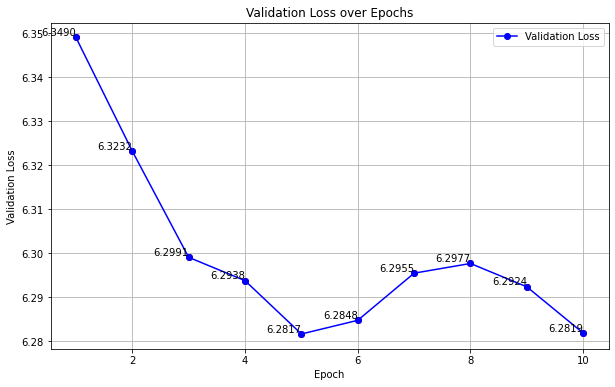

In [13]:
MY_MODELS_PATH = os.path.join(PROJECT_PATH, 'my_models')
def show_simple_baseline_loss(last_epoch):
    files_simple_baseline = [file for file in os.listdir(MY_MODELS_PATH) if file.startswith('simple_baseline')]
    files_simple_baseline = sorted(
                            files_simple_baseline,
                            key=lambda x: int(x.split('-epoch-')[1].split('-')[0])
                            )[:last_epoch]

    # for file in files_simple_baseline:
    #     print(file)

    val_losses_simple_baseline = [float(file_name.split('-loss-')[1].split('.h5')[0])
                                  for file_name in files_simple_baseline]

    epochs = list(range(1, last_epoch+1))

    plt.figure(figsize=(10,6))
    plt.plot(epochs, val_losses_simple_baseline, marker='o', linestyle='-', color='b', label='Validation Loss')
    plt.scatter(epochs, val_losses_simple_baseline, color='r')

    # Annotating each point with its value
    for i, value in enumerate(val_losses_simple_baseline):
        plt.text(epochs[i], val_losses_simple_baseline[i], f'{value:.4f}', ha='right', va='bottom')

    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend(loc='upper right')

    plt.grid(True)


    plt.show()

show_simple_baseline_loss(10)

# Simple Baseline 추가학습(총 epoch 12)
epoch 9부터 다시 줄어들긴 했으니까 추가적으로 2 정도만 더해보기로

**오히려 val loss가 더증가함**

In [7]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
# epoch 10에서 2번 추가진행
epochs = 2
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007
pre_train_path = os.path.join(PROJECT_PATH, 'my_models', 'simple_baseline-epoch-10-loss-6.2819.h5')

train(epochs,
        learning_rate,
        num_heatmap,
        batch_size,
        train_tfrecords,
        val_tfrecords,
        model_type='simple_baseline',
        pre_train_path=pre_train_path,
        start_epoch=10
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 6.70898819 epoch total loss 6.70898819
Trained batch 2 batch loss 6.23555422 epoch total loss 6.47227097
Trained batch 3 batch loss 6.3651371 epoch total loss 6.43655968
Trained batch 4 batch loss 6.42623091 epoch total loss 6.4339776
Trained batch 5 batch loss 6.45048904 epoch total loss 6.43728
Trained batch 6 batch loss 6.46881771 epoch total loss 6.44253683
Trained batch 7 batch loss 6.38659668 epoch total loss 6.43454504
Trained batch 8 batch loss 6.20981693 epoch total loss 6.40645409
Trained batch 9 batch loss 5.68479204 epoch total loss 6.32626915
Trained batch 10 batch loss 5.59397936 epoch total loss 6.25304031
Trained batch 11 batch loss 5.40879059 epoch total loss 6.17629051
Trained batch 12 batch loss 5.68226528 epoch total loss 6.13512182
Trained batch 13 batch loss 5.42113304 epoch total loss 6.08019972
Trained batch 14 batch loss 5.0659256 epoch total loss 6.00775146
Trained batch 15 batch loss 4.690382 epoch tot

Trained batch 124 batch loss 6.36755514 epoch total loss 6.24823141
Trained batch 125 batch loss 6.35648108 epoch total loss 6.24909782
Trained batch 126 batch loss 6.86683464 epoch total loss 6.254
Trained batch 127 batch loss 6.6695857 epoch total loss 6.25727224
Trained batch 128 batch loss 6.60953617 epoch total loss 6.26002455
Trained batch 129 batch loss 6.61951876 epoch total loss 6.26281118
Trained batch 130 batch loss 6.56903172 epoch total loss 6.26516676
Trained batch 131 batch loss 6.30499458 epoch total loss 6.26547098
Trained batch 132 batch loss 6.46472359 epoch total loss 6.26698
Trained batch 133 batch loss 6.39570093 epoch total loss 6.26794815
Trained batch 134 batch loss 6.27783442 epoch total loss 6.26802158
Trained batch 135 batch loss 6.32935429 epoch total loss 6.26847601
Trained batch 136 batch loss 6.34761333 epoch total loss 6.26905775
Trained batch 137 batch loss 6.50928402 epoch total loss 6.27081108
Trained batch 138 batch loss 6.24341917 epoch total loss 

Trained batch 246 batch loss 5.61626291 epoch total loss 6.27855206
Trained batch 247 batch loss 6.40333128 epoch total loss 6.27905703
Trained batch 248 batch loss 5.68875408 epoch total loss 6.27667665
Trained batch 249 batch loss 5.64224768 epoch total loss 6.27412891
Trained batch 250 batch loss 6.03099585 epoch total loss 6.27315617
Trained batch 251 batch loss 5.59251213 epoch total loss 6.27044439
Trained batch 252 batch loss 5.42507124 epoch total loss 6.26709
Trained batch 253 batch loss 6.29363918 epoch total loss 6.26719475
Trained batch 254 batch loss 6.3490653 epoch total loss 6.26751709
Trained batch 255 batch loss 6.32267141 epoch total loss 6.2677331
Trained batch 256 batch loss 6.33008814 epoch total loss 6.26797676
Trained batch 257 batch loss 6.36943865 epoch total loss 6.26837158
Trained batch 258 batch loss 6.52886486 epoch total loss 6.26938057
Trained batch 259 batch loss 6.61749268 epoch total loss 6.27072477
Trained batch 260 batch loss 6.58842611 epoch total l

Trained batch 368 batch loss 6.55966282 epoch total loss 6.28649092
Trained batch 369 batch loss 6.31785965 epoch total loss 6.28657627
Trained batch 370 batch loss 6.30429649 epoch total loss 6.28662395
Trained batch 371 batch loss 6.7694664 epoch total loss 6.28792524
Trained batch 372 batch loss 6.63219786 epoch total loss 6.28885031
Trained batch 373 batch loss 6.44539356 epoch total loss 6.28927
Trained batch 374 batch loss 6.89034176 epoch total loss 6.29087734
Trained batch 375 batch loss 6.83658409 epoch total loss 6.29233265
Trained batch 376 batch loss 6.54177189 epoch total loss 6.29299593
Trained batch 377 batch loss 6.32189894 epoch total loss 6.29307222
Trained batch 378 batch loss 6.56356192 epoch total loss 6.29378796
Trained batch 379 batch loss 6.78251123 epoch total loss 6.29507732
Trained batch 380 batch loss 6.65743256 epoch total loss 6.296031
Trained batch 381 batch loss 6.61250067 epoch total loss 6.29686165
Trained batch 382 batch loss 6.72765207 epoch total lo

Trained batch 490 batch loss 6.33776331 epoch total loss 6.29851055
Trained batch 491 batch loss 5.96410847 epoch total loss 6.29782963
Trained batch 492 batch loss 6.1177516 epoch total loss 6.29746342
Trained batch 493 batch loss 5.97105026 epoch total loss 6.29680109
Trained batch 494 batch loss 6.05761957 epoch total loss 6.2963171
Trained batch 495 batch loss 6.12782335 epoch total loss 6.29597664
Trained batch 496 batch loss 6.46563911 epoch total loss 6.29631901
Trained batch 497 batch loss 6.20382738 epoch total loss 6.29613256
Trained batch 498 batch loss 5.90116167 epoch total loss 6.29533958
Trained batch 499 batch loss 6.31445694 epoch total loss 6.29537773
Trained batch 500 batch loss 6.51039553 epoch total loss 6.29580832
Trained batch 501 batch loss 6.38494539 epoch total loss 6.29598618
Trained batch 502 batch loss 6.31208372 epoch total loss 6.29601812
Trained batch 503 batch loss 6.50861359 epoch total loss 6.2964406
Trained batch 504 batch loss 6.31152058 epoch total

Trained batch 612 batch loss 6.32923555 epoch total loss 6.29792547
Trained batch 613 batch loss 6.3593 epoch total loss 6.29802561
Trained batch 614 batch loss 6.27685642 epoch total loss 6.29799128
Trained batch 615 batch loss 6.41868353 epoch total loss 6.29818726
Trained batch 616 batch loss 6.91346121 epoch total loss 6.29918623
Trained batch 617 batch loss 6.98070145 epoch total loss 6.30029106
Trained batch 618 batch loss 6.6634326 epoch total loss 6.30087852
Trained batch 619 batch loss 6.60616064 epoch total loss 6.30137157
Trained batch 620 batch loss 6.74654436 epoch total loss 6.30208969
Trained batch 621 batch loss 6.24862337 epoch total loss 6.30200338
Trained batch 622 batch loss 6.18519545 epoch total loss 6.30181599
Trained batch 623 batch loss 6.43665886 epoch total loss 6.30203247
Trained batch 624 batch loss 6.76751328 epoch total loss 6.30277872
Trained batch 625 batch loss 6.49477816 epoch total loss 6.3030858
Trained batch 626 batch loss 6.55156469 epoch total lo

Trained batch 734 batch loss 6.29256821 epoch total loss 6.3069272
Trained batch 735 batch loss 6.34283447 epoch total loss 6.30697632
Trained batch 736 batch loss 6.16660643 epoch total loss 6.30678511
Trained batch 737 batch loss 6.43868208 epoch total loss 6.30696392
Trained batch 738 batch loss 6.29135799 epoch total loss 6.30694294
Trained batch 739 batch loss 6.09507465 epoch total loss 6.30665636
Trained batch 740 batch loss 6.49092245 epoch total loss 6.30690527
Trained batch 741 batch loss 6.24880838 epoch total loss 6.30682707
Trained batch 742 batch loss 6.82718372 epoch total loss 6.3075285
Trained batch 743 batch loss 6.33046961 epoch total loss 6.30755949
Trained batch 744 batch loss 6.44095421 epoch total loss 6.30773878
Trained batch 745 batch loss 6.17851925 epoch total loss 6.30756521
Trained batch 746 batch loss 6.62435961 epoch total loss 6.30799
Trained batch 747 batch loss 6.26224184 epoch total loss 6.30792904
Trained batch 748 batch loss 6.4391861 epoch total lo

Trained batch 856 batch loss 6.43528795 epoch total loss 6.29292
Trained batch 857 batch loss 6.8647337 epoch total loss 6.29358768
Trained batch 858 batch loss 6.46654463 epoch total loss 6.29378891
Trained batch 859 batch loss 6.25135279 epoch total loss 6.29373932
Trained batch 860 batch loss 6.34508657 epoch total loss 6.2937994
Trained batch 861 batch loss 6.09228563 epoch total loss 6.29356527
Trained batch 862 batch loss 6.4881382 epoch total loss 6.29379129
Trained batch 863 batch loss 6.60817051 epoch total loss 6.2941556
Trained batch 864 batch loss 6.05902815 epoch total loss 6.2938838
Trained batch 865 batch loss 6.37351131 epoch total loss 6.29397583
Trained batch 866 batch loss 6.12938452 epoch total loss 6.29378557
Trained batch 867 batch loss 5.88878059 epoch total loss 6.29331827
Trained batch 868 batch loss 6.56114864 epoch total loss 6.29362679
Trained batch 869 batch loss 5.66099072 epoch total loss 6.29289913
Trained batch 870 batch loss 6.18741035 epoch total loss

Trained batch 978 batch loss 6.15233469 epoch total loss 6.28950834
Trained batch 979 batch loss 6.19897652 epoch total loss 6.28941631
Trained batch 980 batch loss 6.09671164 epoch total loss 6.28921938
Trained batch 981 batch loss 5.92959929 epoch total loss 6.28885317
Trained batch 982 batch loss 6.11861944 epoch total loss 6.2886796
Trained batch 983 batch loss 6.12361097 epoch total loss 6.28851175
Trained batch 984 batch loss 5.96795034 epoch total loss 6.2881856
Trained batch 985 batch loss 6.22080755 epoch total loss 6.28811693
Trained batch 986 batch loss 5.78648663 epoch total loss 6.28760862
Trained batch 987 batch loss 6.02564 epoch total loss 6.2873435
Trained batch 988 batch loss 6.27845526 epoch total loss 6.28733444
Trained batch 989 batch loss 6.45524883 epoch total loss 6.28750372
Trained batch 990 batch loss 6.42524385 epoch total loss 6.28764296
Trained batch 991 batch loss 6.49187088 epoch total loss 6.28784895
Trained batch 992 batch loss 6.04033089 epoch total lo

Trained batch 1099 batch loss 5.7664938 epoch total loss 6.28255272
Trained batch 1100 batch loss 6.04174185 epoch total loss 6.28233337
Trained batch 1101 batch loss 5.90994215 epoch total loss 6.2819953
Trained batch 1102 batch loss 5.74746275 epoch total loss 6.28151035
Trained batch 1103 batch loss 6.33346176 epoch total loss 6.28155756
Trained batch 1104 batch loss 6.34211206 epoch total loss 6.28161287
Trained batch 1105 batch loss 6.67416143 epoch total loss 6.28196812
Trained batch 1106 batch loss 6.40893841 epoch total loss 6.28208303
Trained batch 1107 batch loss 6.56679296 epoch total loss 6.28234053
Trained batch 1108 batch loss 6.4176631 epoch total loss 6.28246212
Trained batch 1109 batch loss 6.20374584 epoch total loss 6.28239107
Trained batch 1110 batch loss 6.23694563 epoch total loss 6.28235
Trained batch 1111 batch loss 6.55218267 epoch total loss 6.28259325
Trained batch 1112 batch loss 6.37467241 epoch total loss 6.28267574
Trained batch 1113 batch loss 6.30123472

Trained batch 1219 batch loss 6.89048576 epoch total loss 6.28730106
Trained batch 1220 batch loss 6.84398556 epoch total loss 6.28775692
Trained batch 1221 batch loss 6.14225578 epoch total loss 6.28763771
Trained batch 1222 batch loss 6.42602777 epoch total loss 6.2877512
Trained batch 1223 batch loss 6.28704453 epoch total loss 6.28775072
Trained batch 1224 batch loss 6.92433834 epoch total loss 6.28827047
Trained batch 1225 batch loss 6.87703657 epoch total loss 6.28875113
Trained batch 1226 batch loss 6.43442059 epoch total loss 6.28887033
Trained batch 1227 batch loss 6.31447029 epoch total loss 6.28889084
Trained batch 1228 batch loss 6.41273212 epoch total loss 6.28899193
Trained batch 1229 batch loss 6.48027658 epoch total loss 6.28914738
Trained batch 1230 batch loss 6.57969618 epoch total loss 6.28938389
Trained batch 1231 batch loss 7.00669765 epoch total loss 6.28996658
Trained batch 1232 batch loss 6.80025625 epoch total loss 6.29038048
Trained batch 1233 batch loss 6.915

Trained batch 1339 batch loss 6.19966698 epoch total loss 6.29365873
Trained batch 1340 batch loss 6.25718689 epoch total loss 6.29363108
Trained batch 1341 batch loss 6.31812239 epoch total loss 6.29364967
Trained batch 1342 batch loss 6.13682842 epoch total loss 6.29353285
Trained batch 1343 batch loss 6.08371449 epoch total loss 6.29337645
Trained batch 1344 batch loss 6.2676549 epoch total loss 6.29335737
Trained batch 1345 batch loss 6.61836529 epoch total loss 6.29359913
Trained batch 1346 batch loss 6.18190527 epoch total loss 6.29351568
Trained batch 1347 batch loss 6.19214439 epoch total loss 6.29344082
Trained batch 1348 batch loss 6.12483215 epoch total loss 6.29331589
Trained batch 1349 batch loss 6.29129 epoch total loss 6.29331398
Trained batch 1350 batch loss 5.9975071 epoch total loss 6.29309464
Trained batch 1351 batch loss 6.08165836 epoch total loss 6.29293823
Trained batch 1352 batch loss 6.09199572 epoch total loss 6.29278946
Trained batch 1353 batch loss 6.1933226

Validated batch 117 batch loss 6.43357468
Validated batch 118 batch loss 6.41576672
Validated batch 119 batch loss 6.30358791
Validated batch 120 batch loss 6.34531927
Validated batch 121 batch loss 6.58231735
Validated batch 122 batch loss 6.23371363
Validated batch 123 batch loss 6.11220741
Validated batch 124 batch loss 6.09277296
Validated batch 125 batch loss 6.24851036
Validated batch 126 batch loss 6.42659903
Validated batch 127 batch loss 6.20889759
Validated batch 128 batch loss 6.18083525
Validated batch 129 batch loss 5.99854183
Validated batch 130 batch loss 6.21731901
Validated batch 131 batch loss 6.37969923
Validated batch 132 batch loss 6.44974327
Validated batch 133 batch loss 6.52615929
Validated batch 134 batch loss 6.82446146
Validated batch 135 batch loss 7.13261604
Validated batch 136 batch loss 6.85816
Validated batch 137 batch loss 6.25737143
Validated batch 138 batch loss 5.99997854
Validated batch 139 batch loss 6.2577467
Validated batch 140 batch loss 6.74603

Trained batch 78 batch loss 6.59768248 epoch total loss 6.2297821
Trained batch 79 batch loss 6.41053724 epoch total loss 6.23207
Trained batch 80 batch loss 6.38777876 epoch total loss 6.23401642
Trained batch 81 batch loss 6.68356228 epoch total loss 6.23956633
Trained batch 82 batch loss 6.69496822 epoch total loss 6.24512
Trained batch 83 batch loss 6.41130733 epoch total loss 6.24712229
Trained batch 84 batch loss 6.25246286 epoch total loss 6.24718571
Trained batch 85 batch loss 6.27110195 epoch total loss 6.24746752
Trained batch 86 batch loss 6.61178923 epoch total loss 6.25170422
Trained batch 87 batch loss 6.87068367 epoch total loss 6.25881863
Trained batch 88 batch loss 6.68009281 epoch total loss 6.26360607
Trained batch 89 batch loss 6.31896257 epoch total loss 6.26422787
Trained batch 90 batch loss 6.3211832 epoch total loss 6.26486063
Trained batch 91 batch loss 6.30435085 epoch total loss 6.26529455
Trained batch 92 batch loss 6.28437519 epoch total loss 6.2655015
Trai

Trained batch 200 batch loss 6.40693426 epoch total loss 6.2537446
Trained batch 201 batch loss 6.2971096 epoch total loss 6.25396
Trained batch 202 batch loss 6.07691574 epoch total loss 6.25308371
Trained batch 203 batch loss 5.79759359 epoch total loss 6.25084
Trained batch 204 batch loss 6.24103355 epoch total loss 6.25079203
Trained batch 205 batch loss 6.65519571 epoch total loss 6.2527647
Trained batch 206 batch loss 6.55338 epoch total loss 6.25422382
Trained batch 207 batch loss 6.1322751 epoch total loss 6.25363493
Trained batch 208 batch loss 6.19201136 epoch total loss 6.25333881
Trained batch 209 batch loss 6.08286095 epoch total loss 6.25252295
Trained batch 210 batch loss 6.34401083 epoch total loss 6.25295877
Trained batch 211 batch loss 6.8058691 epoch total loss 6.25557947
Trained batch 212 batch loss 6.54597282 epoch total loss 6.25694942
Trained batch 213 batch loss 6.40591145 epoch total loss 6.25764847
Trained batch 214 batch loss 6.22020149 epoch total loss 6.257

Trained batch 322 batch loss 6.47597075 epoch total loss 6.24369335
Trained batch 323 batch loss 6.12130642 epoch total loss 6.24331427
Trained batch 324 batch loss 5.93059301 epoch total loss 6.24234915
Trained batch 325 batch loss 6.40621948 epoch total loss 6.24285364
Trained batch 326 batch loss 6.56969213 epoch total loss 6.24385595
Trained batch 327 batch loss 6.65626287 epoch total loss 6.24511719
Trained batch 328 batch loss 6.60098934 epoch total loss 6.24620247
Trained batch 329 batch loss 6.44873428 epoch total loss 6.24681807
Trained batch 330 batch loss 7.11271286 epoch total loss 6.2494421
Trained batch 331 batch loss 6.74744749 epoch total loss 6.250947
Trained batch 332 batch loss 6.44225407 epoch total loss 6.25152302
Trained batch 333 batch loss 6.02418661 epoch total loss 6.25084
Trained batch 334 batch loss 5.86403 epoch total loss 6.24968195
Trained batch 335 batch loss 5.26650286 epoch total loss 6.24674749
Trained batch 336 batch loss 5.84959888 epoch total loss 

Trained batch 444 batch loss 5.25514746 epoch total loss 6.24602938
Trained batch 445 batch loss 5.67207146 epoch total loss 6.24473953
Trained batch 446 batch loss 5.69252682 epoch total loss 6.24350166
Trained batch 447 batch loss 5.95765114 epoch total loss 6.2428627
Trained batch 448 batch loss 5.86312 epoch total loss 6.24201488
Trained batch 449 batch loss 6.08633375 epoch total loss 6.24166822
Trained batch 450 batch loss 6.29293299 epoch total loss 6.24178219
Trained batch 451 batch loss 6.4986825 epoch total loss 6.24235201
Trained batch 452 batch loss 6.06086731 epoch total loss 6.24195051
Trained batch 453 batch loss 6.35937309 epoch total loss 6.24220943
Trained batch 454 batch loss 7.23087883 epoch total loss 6.24438763
Trained batch 455 batch loss 6.83891249 epoch total loss 6.24569416
Trained batch 456 batch loss 7.36757803 epoch total loss 6.24815464
Trained batch 457 batch loss 6.81672192 epoch total loss 6.24939823
Trained batch 458 batch loss 6.63733053 epoch total l

Trained batch 566 batch loss 6.68755817 epoch total loss 6.2646203
Trained batch 567 batch loss 6.79402 epoch total loss 6.26555395
Trained batch 568 batch loss 6.13356113 epoch total loss 6.26532173
Trained batch 569 batch loss 6.39230061 epoch total loss 6.26554489
Trained batch 570 batch loss 6.23570108 epoch total loss 6.26549244
Trained batch 571 batch loss 6.4693203 epoch total loss 6.26584911
Trained batch 572 batch loss 6.4656558 epoch total loss 6.26619816
Trained batch 573 batch loss 6.55730534 epoch total loss 6.26670647
Trained batch 574 batch loss 6.16847563 epoch total loss 6.26653528
Trained batch 575 batch loss 6.24757957 epoch total loss 6.26650238
Trained batch 576 batch loss 6.45237637 epoch total loss 6.26682472
Trained batch 577 batch loss 6.29592943 epoch total loss 6.26687527
Trained batch 578 batch loss 6.51827955 epoch total loss 6.26731
Trained batch 579 batch loss 6.38148975 epoch total loss 6.26750755
Trained batch 580 batch loss 6.3068552 epoch total loss 6

Trained batch 688 batch loss 6.56411886 epoch total loss 6.26948
Trained batch 689 batch loss 6.13966465 epoch total loss 6.26929188
Trained batch 690 batch loss 6.54081106 epoch total loss 6.26968575
Trained batch 691 batch loss 6.20628166 epoch total loss 6.26959324
Trained batch 692 batch loss 6.40280151 epoch total loss 6.26978588
Trained batch 693 batch loss 6.40750217 epoch total loss 6.2699852
Trained batch 694 batch loss 6.55622149 epoch total loss 6.27039719
Trained batch 695 batch loss 6.61825085 epoch total loss 6.27089787
Trained batch 696 batch loss 6.21048212 epoch total loss 6.27081108
Trained batch 697 batch loss 5.65136 epoch total loss 6.26992226
Trained batch 698 batch loss 5.27705622 epoch total loss 6.26849937
Trained batch 699 batch loss 6.09821177 epoch total loss 6.26825571
Trained batch 700 batch loss 6.46229458 epoch total loss 6.26853323
Trained batch 701 batch loss 6.13833332 epoch total loss 6.26834726
Trained batch 702 batch loss 6.11561966 epoch total los

Trained batch 810 batch loss 6.34336424 epoch total loss 6.29259872
Trained batch 811 batch loss 6.27159 epoch total loss 6.2925725
Trained batch 812 batch loss 6.34558487 epoch total loss 6.29263783
Trained batch 813 batch loss 6.54098606 epoch total loss 6.29294348
Trained batch 814 batch loss 6.4141736 epoch total loss 6.29309225
Trained batch 815 batch loss 6.0920167 epoch total loss 6.29284525
Trained batch 816 batch loss 6.26008034 epoch total loss 6.29280519
Trained batch 817 batch loss 6.30106735 epoch total loss 6.29281569
Trained batch 818 batch loss 6.44906616 epoch total loss 6.2930069
Trained batch 819 batch loss 6.35921907 epoch total loss 6.29308796
Trained batch 820 batch loss 6.46126747 epoch total loss 6.29329348
Trained batch 821 batch loss 6.24578 epoch total loss 6.2932353
Trained batch 822 batch loss 6.00579309 epoch total loss 6.29288578
Trained batch 823 batch loss 6.27567625 epoch total loss 6.2928648
Trained batch 824 batch loss 6.27315187 epoch total loss 6.2

Trained batch 932 batch loss 6.31587315 epoch total loss 6.29487276
Trained batch 933 batch loss 6.45116186 epoch total loss 6.29504
Trained batch 934 batch loss 6.31907511 epoch total loss 6.2950654
Trained batch 935 batch loss 6.22363758 epoch total loss 6.29498911
Trained batch 936 batch loss 5.94168043 epoch total loss 6.29461193
Trained batch 937 batch loss 6.29463625 epoch total loss 6.29461193
Trained batch 938 batch loss 6.24610519 epoch total loss 6.29456
Trained batch 939 batch loss 6.31169701 epoch total loss 6.29457808
Trained batch 940 batch loss 6.44492912 epoch total loss 6.29473782
Trained batch 941 batch loss 6.51108789 epoch total loss 6.29496813
Trained batch 942 batch loss 6.63519669 epoch total loss 6.29532909
Trained batch 943 batch loss 6.6949892 epoch total loss 6.295753
Trained batch 944 batch loss 6.54408121 epoch total loss 6.29601574
Trained batch 945 batch loss 6.0275836 epoch total loss 6.29573154
Trained batch 946 batch loss 6.19427109 epoch total loss 6.

Trained batch 1053 batch loss 6.54976416 epoch total loss 6.29162312
Trained batch 1054 batch loss 6.30833435 epoch total loss 6.29163885
Trained batch 1055 batch loss 6.57269716 epoch total loss 6.2919054
Trained batch 1056 batch loss 6.17526054 epoch total loss 6.29179478
Trained batch 1057 batch loss 6.10784245 epoch total loss 6.29162073
Trained batch 1058 batch loss 6.01263952 epoch total loss 6.29135704
Trained batch 1059 batch loss 5.93588591 epoch total loss 6.29102182
Trained batch 1060 batch loss 6.37987661 epoch total loss 6.29110527
Trained batch 1061 batch loss 5.93375683 epoch total loss 6.29076862
Trained batch 1062 batch loss 6.01358557 epoch total loss 6.29050779
Trained batch 1063 batch loss 6.25590181 epoch total loss 6.29047489
Trained batch 1064 batch loss 6.43344 epoch total loss 6.29060936
Trained batch 1065 batch loss 6.16941452 epoch total loss 6.29049587
Trained batch 1066 batch loss 6.08753347 epoch total loss 6.29030514
Trained batch 1067 batch loss 6.406378

Trained batch 1173 batch loss 6.14353085 epoch total loss 6.2899642
Trained batch 1174 batch loss 6.15245247 epoch total loss 6.2898469
Trained batch 1175 batch loss 6.06363344 epoch total loss 6.28965425
Trained batch 1176 batch loss 6.68144941 epoch total loss 6.28998756
Trained batch 1177 batch loss 6.28210878 epoch total loss 6.28998089
Trained batch 1178 batch loss 6.43640661 epoch total loss 6.29010534
Trained batch 1179 batch loss 6.13158655 epoch total loss 6.28997087
Trained batch 1180 batch loss 6.18845415 epoch total loss 6.28988457
Trained batch 1181 batch loss 6.1748662 epoch total loss 6.28978729
Trained batch 1182 batch loss 6.32928896 epoch total loss 6.28982067
Trained batch 1183 batch loss 6.37143707 epoch total loss 6.28989
Trained batch 1184 batch loss 6.55928898 epoch total loss 6.29011679
Trained batch 1185 batch loss 6.87425756 epoch total loss 6.29061
Trained batch 1186 batch loss 6.85166597 epoch total loss 6.29108286
Trained batch 1187 batch loss 7.04597521 ep

Trained batch 1293 batch loss 5.61569071 epoch total loss 6.28672314
Trained batch 1294 batch loss 5.84747887 epoch total loss 6.28638363
Trained batch 1295 batch loss 6.27560759 epoch total loss 6.28637505
Trained batch 1296 batch loss 6.40122 epoch total loss 6.28646421
Trained batch 1297 batch loss 6.53853607 epoch total loss 6.28665829
Trained batch 1298 batch loss 6.56966591 epoch total loss 6.28687668
Trained batch 1299 batch loss 6.59722948 epoch total loss 6.28711557
Trained batch 1300 batch loss 6.09339619 epoch total loss 6.28696632
Trained batch 1301 batch loss 5.85572147 epoch total loss 6.28663492
Trained batch 1302 batch loss 6.1755476 epoch total loss 6.28655
Trained batch 1303 batch loss 6.47248363 epoch total loss 6.28669262
Trained batch 1304 batch loss 6.48177481 epoch total loss 6.28684187
Trained batch 1305 batch loss 6.25542736 epoch total loss 6.2868185
Trained batch 1306 batch loss 6.79891491 epoch total loss 6.28721046
Trained batch 1307 batch loss 6.6917758 ep

Validated batch 40 batch loss 6.60531569
Validated batch 41 batch loss 6.57298422
Validated batch 42 batch loss 6.94015503
Validated batch 43 batch loss 7.08834839
Validated batch 44 batch loss 6.73950195
Validated batch 45 batch loss 6.29397392
Validated batch 46 batch loss 5.98693085
Validated batch 47 batch loss 6.49913216
Validated batch 48 batch loss 6.27976847
Validated batch 49 batch loss 6.15603209
Validated batch 50 batch loss 6.03266335
Validated batch 51 batch loss 6.09877157
Validated batch 52 batch loss 6.37785244
Validated batch 53 batch loss 6.17515898
Validated batch 54 batch loss 6.38256311
Validated batch 55 batch loss 6.4919157
Validated batch 56 batch loss 6.3122797
Validated batch 57 batch loss 6.16811037
Validated batch 58 batch loss 5.80219364
Validated batch 59 batch loss 6.61616898
Validated batch 60 batch loss 6.21972561
Validated batch 61 batch loss 6.34787369
Validated batch 62 batch loss 6.22848606
Validated batch 63 batch loss 6.28318644
Validated batch 64

'/aiffel/aiffel/workspace/24_pose/data/my_models/simple_baseline-epoch-12-loss-6.3070.h5'

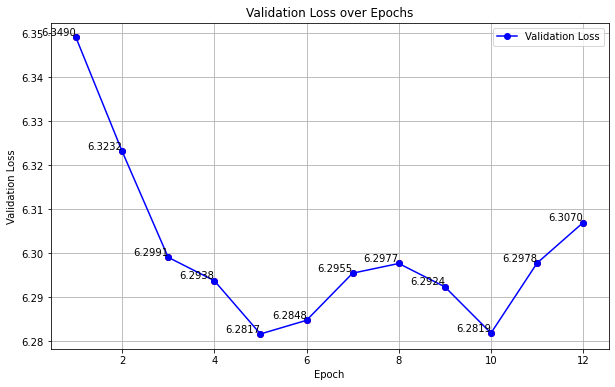

In [11]:
show_simple_baseline_loss(12)

# 한번에 비교하기

In [43]:
# 학습했던 모델들 불러오기
# hourglass epoch 5
# simple basline 5, 10, 12

"""
stacked hourglass epoch 5
"""
model_stacked_hourglass = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model_stacked_hourglass.load_weights(MY_MODELS_PATH+'/my_model-epoch-2+3-loss-1.1699.h5')

"""
simple baseline epoch 5
"""
model_simple_baseline_5 = Simplebaseline()
model_simple_baseline_5.load_weights(MY_MODELS_PATH+'/simple_baseline-epoch-5-loss-6.2817.h5')

"""
simple baseline epoch 10
"""
model_simple_baseline_10 = Simplebaseline()
model_simple_baseline_10.load_weights(MY_MODELS_PATH+'/simple_baseline-epoch-10-loss-6.2819.h5')

"""
simple baseline epoch 12
"""
model_simple_baseline_12 = Simplebaseline()
model_simple_baseline_12.load_weights(MY_MODELS_PATH+'/simple_baseline-epoch-12-loss-6.3070.h5')

In [49]:
models = [
    model_stacked_hourglass,
    model_simple_baseline_5,
    model_simple_baseline_10,
    model_simple_baseline_12
]

test_images = [f'{PROJECT_PATH}/test_image.jpg', f'{PROJECT_PATH}/test_image2.jpg', f'{PROJECT_PATH}/test_image3.jpg', f'{PROJECT_PATH}/test_image4.jpg',
               f'{PROJECT_PATH}/test_image5.jpg', f'{PROJECT_PATH}/test_image6.jpg', f'{PROJECT_PATH}/test_image7.jpg', f'{PROJECT_PATH}/test_image8.jpg',
               f'{PROJECT_PATH}/test_image9.jpg', f'{PROJECT_PATH}/test_image10.jpg']

In [52]:
def compare_images(models, test_images):
    multi_images = []
    multi_keypoints = []
        
    for model in models:
        images = []
        keypoints = []
        for image_path in test_images:
            image, keypoint = predict(model, image_path)
            images.append(image)
            keypoints.append(keypoint)
        multi_images.append(images)
        multi_keypoints.append(keypoints)
    
    # 그림 크기 설정
    plt.figure(figsize=(15, 20))
    
    model_names = ['stacked_hourglass_5', 'model_simple_baseline_5', 'model_simple_baseline_10', 'model_simple_baseline_12']
    for i, test_image in enumerate(test_images):
        for j, model in enumerate(models):
            plt.subplot(len(test_images), 4, i * 4 + j + 1)
            plt.imshow(multi_images[j][i])
            keypoints = multi_keypoints[j][i]
            joints = []
            for k, joint in enumerate(keypoints):
                joint_x = joint[0] * multi_images[j][i].shape[1]
                joint_y = joint[1] * multi_images[j][i].shape[0]
                joints.append((joint_x, joint_y))

            for bone in MPII_BONES:
                joint_1 = joints[bone[0]]
                joint_2 = joints[bone[1]]
                plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=2, alpha=0.7, color='blue')
            
            plt.axis('off')
            if i == 0:
                plt.title(f'Model {model_names[j]}')
    
    plt.tight_layout()
    plt.show()

# hourglass 성능 > simple baseline
- 사람이 한명 이미지
    - 육안으로 확인해보았을때 hourglass epoch 5짜리가 더 좋은 성능을 보여준다.
- 사람이 여러명 있는 이미지
    - hourglass는 사람의 관절이라고는 볼 수 없는 형태?를 보여준다.
    - simple baseline은 비교적 사람의 형태라고는 볼 수 있는 형태?를 보여준다.

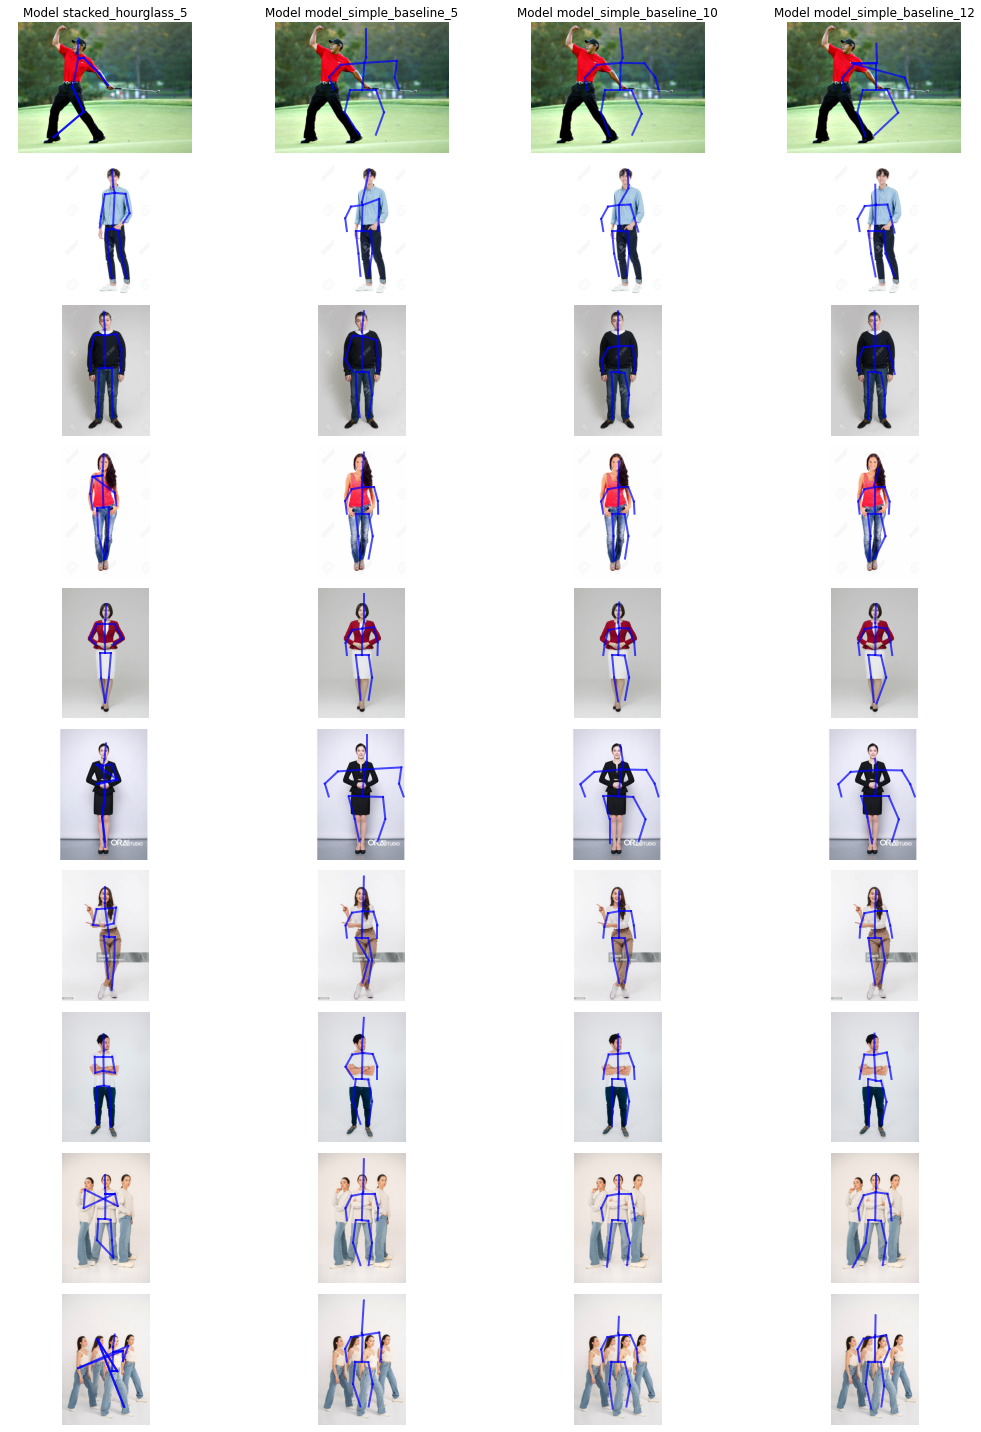

In [53]:
compare_images(models, test_images)

# 회고
- 배운점
    - stakced hourglass 구현방법과 simple baseline 모델 구현방법
- 느낀점
    - baseline에 대해 노드에서 학습할때 baseline이 hourglass보다 더 빠르고, 성능도 좋을줄 알았지만 기대와는 다르게 성능이 더 낮게 나왔다.
- 아쉬운점
    - simple baseline의 성능이 너무 안좋아서, simple baseline만 추가적으로 조금 더 학습을 진행했는데 성능이 개선되지 않았다.
    - stacked hourglass는 시간상 baseline모델과 똑같은 epoch으로 훈련하지 못했다.
- 어려웠던점
    - simple baseline을 학습시키려고 기존 hourglass 모델을 학습한 코드에서 model 만 변경해서 train했더니 class Train에서 def compute_loss함수에서 에러가나왔다. baseline을 학습하는 코드에도 에러내용을 정리해두었지만 아직 정확한 원인을 모르겠다.